# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [2]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


     |████████████████████████████████| 92.5MB 80kB/s 
     |████████████████████████████████| 368kB 41.1MB/s 
     |████████████████████████████████| 3.2MB 36.0MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-gumz184d
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-gumz184d
  Created wheel for wordroid.sblo.jp: filename=wordroid.sblo.jp-0.0.1-cp36-none-any.whl size=33710 sha256=78733a92f5a6342210384765748098cd21945eff2277cb2ebf413e2085a0df60
  Stored in directory: /tmp/pip-ephem-wheel-cache-pg2trkrf/wheels/3d/6d/24/44e7d6dc47b39e74772a04beb27433ba2ebed90876394cda60
Successfully built wordroid.sblo.jp


In [0]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(0)
np.random.seed(0)

# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,self.imsize)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(28,28),self.img.reshape(28,28)) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(28,28),self.img.reshape(28,28))
        individual = self.X_best.reshape(1,self.imsize)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"16oao6c9BTb33sbaFzCDJ1sGQn4Z0ILS7"}) 
downloaded.GetContentFile('rbfnn_v2.h5')   

num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn_v2.h5")

# Prepare Data

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def prepare_data(X,y):
  X = X.reshape((X.shape[0], -1))
  X_sc = X / 255.0
  y_cat = to_categorical(y)
  return X_sc, y_cat

In [10]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
X_sc.shape
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(X_test_sc)
y_pred_train = model.predict(X_sc)
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.93305
Test accuracy:  0.9297


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [13]:
subsample.shape

(1021, 784)

In [14]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(subsample_sc)

In [16]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9333986287952988


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [18]:
original.shape

(895, 784)

In [19]:
adversarial.shape

(126, 784)

In [20]:
adversarial_y.shape

(126,)

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 20, #50 (5) #200 (1)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2) (it was 2000)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4) (it was 125)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  0.653361806907975 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  0.7485476214322659 25
75  :  0.7489170230039236 25
100  :  0.728030224451736 25
125  :  0.750075925492276 25
150  :  0.7304273690323683 25
175  :  0.7330973763049928 25
200  :  0.7619111828101861 25
225  :  0.765499628589719 25
250  :  0.7668883484139515 25
275  :  0.7670579148983413 25
300  :  0.7727459088356683 25
325  :  0.7727459088356683 25
350  :  0.7788817713890979 25
375  :  0.781540523713985 25
400  :  0.7818032967693114 25
425  :  0.7818032967693114 25
450  :  0.7848572031860492 25
475  :  0.7869978242981817 25
500  :  0.7872765818481073 25
525  :  0.7890891028598109 25
550  :  0.789958341152027 25
575  :  0.7912755311189521 25
600  :  0.7927463173962155 25
625  :  0.7932871027484665 25
650  :  0.79451027169493 25
675  :  0.7960937540456127 25
700  :  0.7964878647823275 25
725  :  0.7978262239468218 25
750  :  0.7978753061081262 25
775  :  0.7983970463942202 25
800  :  0.7998451699258599 25
825  :  0.7998324697702857 25
850  :  0.7998324697702857 25
875  :  0.801085875

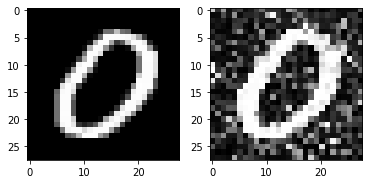

25  :  0.6472607927869485 25
50  :  0.7396028771886614 25
75  :  0.7452444378879615 25
100  :  0.7260835029012955 25
125  :  0.7237687851799952 25
150  :  0.7344715668435858 25
175  :  0.7644765901198884 25
200  :  0.767250981114179 25
225  :  0.7742785058784842 25
250  :  0.7784560850706297 25
275  :  0.7805056100329952 25
300  :  0.780419703188729 25
325  :  0.7856642717878446 25
350  :  0.7879261166732663 25
375  :  0.7927040018664961 25
400  :  0.7932904764276332 25
425  :  0.7970518949843491 25
450  :  0.8001898659865243 25
475  :  0.8036616797429905 25
500  :  0.8040468703810002 25
525  :  0.8053124616844807 25
550  :  0.8053124616844807 25
575  :  0.8053913302397038 25
600  :  0.8054041266079127 25
625  :  0.8062731297236686 25
650  :  0.8070895183620559 25
675  :  0.8083406674379428 25
700  :  0.8092592163552643 25
725  :  0.8102912297140105 25
750  :  0.8121595292784438 25
775  :  0.8125945983491312 25
800  :  0.8145506459696819 25
825  :  0.8143673418191553 25
850  :  0.81633

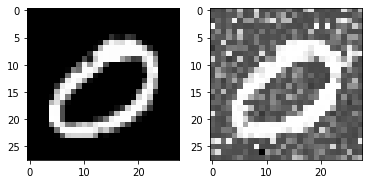

25  :  0.6080907291748663 25
50  :  0.7318416450418901 25
75  :  0.7463386370516851 25
100  :  0.7422106814392233 25
125  :  0.7367622184605944 25
150  :  0.7462850800607952 25
175  :  0.7573543210606821 25
200  :  0.7676376724680051 25
225  :  0.7711015017910424 25
250  :  0.7716151405043865 25
275  :  0.7819865991314685 25
300  :  0.7881362130587373 25
325  :  0.7861738619320275 25
350  :  0.7888866708583062 25
375  :  0.7913291723338352 25
400  :  0.792012286803674 25
425  :  0.7930973615841774 25
450  :  0.7932450395514266 25
475  :  0.7960230675982475 25
500  :  0.7961714284461466 25
525  :  0.800146262681863 25
550  :  0.7997452588940095 25
575  :  0.800217555769433 25
600  :  0.8002189124298524 25
625  :  0.801247059145023 25
650  :  0.8019867466414825 25
675  :  0.8019867466414825 25
700  :  0.802061430874625 25
725  :  0.8029223055760851 25
750  :  0.8033318713138391 25
775  :  0.8042196447834467 25
800  :  0.8044718680076824 25
825  :  0.8049750298809757 25
850  :  0.80505705

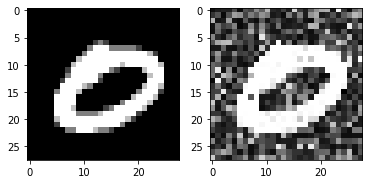

25  :  0.4756605057107631 25
50  :  0.6762969879091565 25
75  :  0.6328847799413796 25
100  :  0.6886663981812949 25
125  :  0.6842068410527867 25
150  :  0.7218691759286598 25
175  :  0.732287686348153 25
200  :  0.7461971276851223 25
225  :  0.7477490873290794 25
250  :  0.7477490873290794 25
275  :  0.7477490873290794 25
300  :  0.7477490873290794 25
325  :  0.7491034090664641 25
350  :  0.7493323414532369 25
375  :  0.7521961932586182 25
400  :  0.7546657456375444 25
425  :  0.7546657456375444 25
450  :  0.7557736168360367 25
475  :  0.7563631604131826 25
500  :  0.7596930907658379 25
525  :  0.7596930907658379 25
550  :  0.761625079042904 25
575  :  0.7620088008641384 25
600  :  0.7647591878208726 25
625  :  0.76505191582675 25
650  :  0.7675839465160079 25
675  :  0.7675979359353362 25
700  :  0.7691074698666005 25
725  :  0.7690997470104236 25
750  :  0.7697433353776837 25
775  :  0.7718526980364506 25
800  :  0.7725241156116027 25
825  :  0.7742380377813814 25
850  :  0.7746326

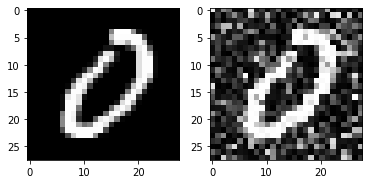

25  :  0.7843611118552138 25
50  :  0.7943040725008375 25
75  :  0.776159133620149 25
100  :  0.7818191284950393 25
125  :  0.8009930145538025 25
150  :  0.7990165833495184 25
175  :  0.8055389737085947 25
200  :  0.8103918457773938 25
225  :  0.8091596752581856 25
250  :  0.8177574224593487 25
275  :  0.8234794617194544 25
300  :  0.8211792234230586 25
325  :  0.824311046436627 25
350  :  0.8267029669116344 25
375  :  0.8264494959634741 25
400  :  0.8264494959634741 25
425  :  0.8264494959634741 25
450  :  0.8264494959634741 25
475  :  0.8264494959634741 25
500  :  0.8286757722195621 25
525  :  0.828591605114455 25
550  :  0.8299314313638415 25
575  :  0.8307734710035428 25
600  :  0.832917666494243 25
625  :  0.83331881007489 25
650  :  0.8333437694299762 25
675  :  0.83331881007489 25
700  :  0.8358156203883252 25
725  :  0.8357619128385538 25
750  :  0.8357619128385538 25
775  :  0.8357619128385538 25
800  :  0.8359851624927647 25
825  :  0.8361020455495644 25
850  :  0.83602478972

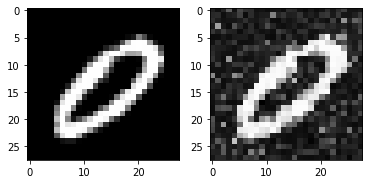

25  :  0.7450153118491354 25
50  :  0.7712545395566568 25
75  :  0.7560044850202468 25
100  :  0.7840328017447048 25
125  :  0.7693220904046022 25
150  :  0.7752423558983649 25
175  :  0.7824987591632722 25
200  :  0.7959312864638993 25
225  :  0.8057426520865199 25
250  :  0.8056433104454828 25
275  :  0.8136059924163928 25
300  :  0.8151923816291038 25
325  :  0.8193105540012188 25
350  :  0.8194798654307787 25
375  :  0.8194798654307787 25
400  :  0.8201640463553239 25
425  :  0.8217260931815715 25
450  :  0.8226108996555687 25
475  :  0.8235073942313238 25
500  :  0.8241114421771738 25
525  :  0.8241009636447395 25
550  :  0.8255667893096896 25
575  :  0.8255324670735702 25
600  :  0.8257220459497623 25
625  :  0.8277594208874728 25
650  :  0.8290785620671024 25
675  :  0.8311389395722322 25
700  :  0.8314608871934999 25
725  :  0.8322569262466424 25
750  :  0.8322322089275935 25
775  :  0.8323579385194573 25
800  :  0.8328040071488267 25
825  :  0.8338738075018522 25
850  :  0.833

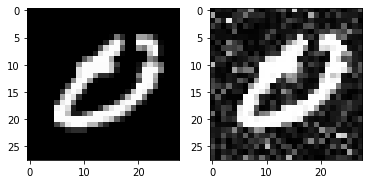

25  :  0.22517946492068797 25
50  :  0.5413391741905116 25
75  :  0.6070789912190591 25
100  :  0.46960367242407436 25
125  :  0.5648288298157536 25
150  :  0.5596761177498204 25
175  :  0.46287202585390386 25
200  :  0.4363250921133733 25
225  :  0.11462152115544538 25
250  :  0.3653158075631555 25
275  :  0.054325674980676586 25
300  :  0.2874251978323854 25
325  :  0.673426128454822 25
350  :  0.741128304171889 25
375  :  0.7482065946600303 25
400  :  0.7555781007693022 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


425  :  0.7560401426751655 25
450  :  0.7633842324897582 25
475  :  0.7631297366541506 25
500  :  0.7631297366541506 25
525  :  0.767096654973865 25
550  :  0.7698096787372635 25
575  :  0.7717036761845228 25
600  :  0.7732778425792297 25
625  :  0.7739721533739092 25
650  :  0.7741628700730285 25
675  :  0.7747404216511404 25
700  :  0.7741628700730285 25
725  :  0.7743194428476415 25
750  :  0.7747517162049173 25
775  :  0.7747517162049173 25
800  :  0.7770594552421937 25
825  :  0.7786959932753458 25
850  :  0.7794162983212543 25
875  :  0.7797068959049493 25
900  :  0.781172262486709 25
925  :  0.7808450695581041 25
950  :  0.7823419018852009 25
975  :  0.7850032090568559 25
1000  :  0.7850032090568559 25
1025  :  0.7863096456447269 25
1050  :  0.7872215520640315 25
1075  :  0.7874510434961258 25
1100  :  0.7874510434961258 25
1125  :  0.7874510434961258 25
Time:  90.26817035675049  seconds
Predicted class:  [5]


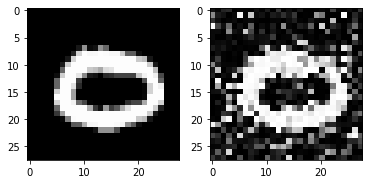

25  :  0.13023927181541883 25
50  :  0.3774101903895758 25
75  :  0.147043588001198 25
100  :  -0.10996434281204148 25
125  :  0.17127130522662876 25
150  :  -0.10581311449048453 25
175  :  -0.10605955945597978 25
200  :  -0.10570384043564407 25
225  :  -0.10513231394438982 25
250  :  -0.10487283743174836 25
275  :  -0.10442976105120783 25
300  :  -0.10447232973580522 25
325  :  -0.10462144853547034 25
350  :  -0.10462144853547034 25
375  :  -0.10431752444237624 25
400  :  -0.10431752444237624 25
425  :  -0.10425616912835645 25
450  :  -0.1042892301152214 25
475  :  -0.1039058799732403 25
500  :  -0.10381560919192012 25
525  :  -0.10319276903164276 25
550  :  -0.10278118180955015 25
575  :  -0.10280618442525746 25
600  :  -0.10280618442525746 25
625  :  -0.10280618442525746 25
650  :  -0.10280618442525746 25
675  :  -0.10266722088362801 25
700  :  -0.10264696061772038 25
725  :  -0.1023958956042621 25
750  :  -0.10237003698458924 25
775  :  -0.10237003698458924 25
800  :  -0.1023680587

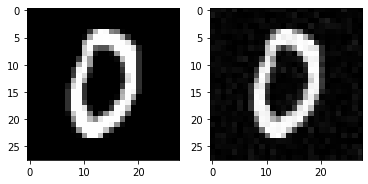

25  :  0.01682498640611263 25
50  :  0.49875026666734945 25
75  :  -0.131791927074551 25
100  :  0.36785894979971073 25
125  :  -0.04130947816420305 25
150  :  0.1800817925911093 25
175  :  0.4601873259702854 25
200  :  0.6007918009880739 25
225  :  0.6058464536253751 25
250  :  0.6096000174038149 25
275  :  0.618480082677843 25
300  :  0.6507107494107593 25
325  :  0.6678122060405077 25
350  :  0.6711883761361304 25
375  :  0.6867999892179425 25
400  :  0.6877171565158241 25
425  :  0.7048185704939285 25
450  :  0.7056523260367545 25
475  :  0.7056920221781511 25
500  :  0.7056920221781511 25
525  :  0.7060999813961968 25
550  :  0.7059978898174062 25
575  :  0.7092337774763791 25
600  :  0.7098286159078969 25
625  :  0.712089227531451 25
650  :  0.7131721652749813 25
675  :  0.7142865707882402 25
700  :  0.7166551765681753 25
725  :  0.716931262577736 25
750  :  0.7171555520058916 25
775  :  0.7185338334208922 25
800  :  0.7198157524333871 25
825  :  0.7219546298876753 25
850  :  0.7

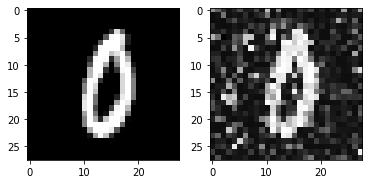

25  :  0.21841222112423003 25
50  :  0.6718817215994074 25
75  :  0.458021423162373 25
100  :  0.25181487179769224 25
125  :  0.5104131844497062 25
150  :  0.37650893429888255 25
175  :  0.44003233060309976 25
200  :  0.6016278604701162 25
225  :  0.6365356965065885 25
250  :  0.7491103200846034 25
275  :  0.7575838815019242 25
300  :  0.7617211797063892 25
325  :  0.7723893712293511 25
350  :  0.7636259497124888 25
375  :  0.7636259497124888 25
400  :  0.7652228074221981 25
425  :  0.7690735826795726 25
450  :  0.7711305534543158 25
475  :  0.7785639022784818 25
500  :  0.7785639022784818 25
525  :  0.7830111281230563 25
550  :  0.7832419236370545 25
575  :  0.7848758351993277 25
600  :  0.784562822876455 25
625  :  0.784562822876455 25
650  :  0.7852722836701915 25
675  :  0.7881986176413216 25
700  :  0.7889967101261096 25
725  :  0.7891669683469962 25
750  :  0.7892812458261347 25
775  :  0.7922982499639288 25
800  :  0.7922488559842804 25
825  :  0.7933076076102807 25
850  :  0.79

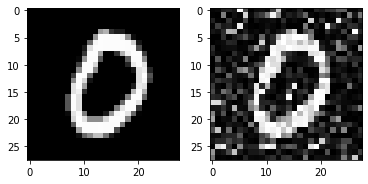

25  :  0.881566459870864 25
50  :  0.881566459870864 25
75  :  0.8766533960720921 25
100  :  0.8806488815215512 25
125  :  0.8824323001999859 25
150  :  0.8887799999398645 25
175  :  0.8885004932952731 25
200  :  0.8885004932952731 25
225  :  0.8885004932952731 25
250  :  0.8889721924376535 25
275  :  0.8885004932952731 25
300  :  0.889179568706028 25
325  :  0.8945821403639376 25
350  :  0.8964882334154138 25
375  :  0.8969628853374922 25
400  :  0.8969707931163777 25
425  :  0.8978406923253784 25
450  :  0.8989740677065676 25
475  :  0.9011132046821066 25
500  :  0.900522017246828 25
525  :  0.9040390324732618 25
550  :  0.9042139394933381 25
575  :  0.9038087203591689 25
600  :  0.9047572742228355 25
625  :  0.9060756478558711 25
650  :  0.9062048247614346 25
675  :  0.9071381049408798 25
700  :  0.9073917580492721 25
725  :  0.9073916497428478 25
750  :  0.9082026642172771 25
775  :  0.9081569101805324 25
800  :  0.9081569101805324 25
Time:  52.145150661468506  seconds
Predicted cl

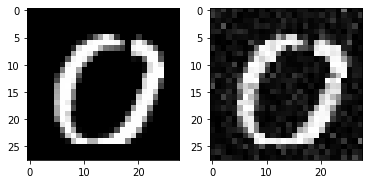

25  :  0.19406519382739956 25
50  :  0.6521887974992464 25
75  :  0.3602019764718762 25
100  :  0.6001783923636681 25
125  :  0.5457964392955503 25
150  :  0.5905903308991445 25
175  :  0.37339195928838065 25
200  :  0.611284623118818 25
225  :  0.6939047523680107 25
250  :  0.7418926230582052 25
275  :  0.7635794516374166 25
300  :  0.7635794516374166 25
325  :  0.7665191140614467 25
350  :  0.7652224407343303 25
375  :  0.7678364736912571 25
400  :  0.7663344730103914 25
425  :  0.7734912955550208 25
450  :  0.7709865234004023 25
475  :  0.7745596282284063 25
500  :  0.7788396775368228 25
525  :  0.7842279489567416 25
550  :  0.7834240148170075 25
575  :  0.7892966521601779 25
600  :  0.7891227282413191 25
625  :  0.7899938867950544 25
650  :  0.7899689238947695 25
675  :  0.7922762289237646 25
700  :  0.7923047313683753 25
725  :  0.7923047313683753 25
750  :  0.7941092090803186 25
775  :  0.7950843420874427 25
800  :  0.796960904064681 25
825  :  0.7976452886037027 25
850  :  0.799

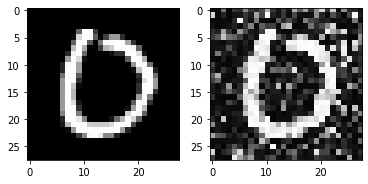

25  :  0.8835858832826009 25
50  :  0.8896102843315126 25
75  :  0.8850268227671853 25
100  :  0.8852589468584118 25
125  :  0.890214954257504 25
150  :  0.8930982084840928 25
175  :  0.8928632307430551 25
200  :  0.8943052720949098 25
225  :  0.8940627416606955 25
250  :  0.8968607583673818 25
275  :  0.898210806790999 25
300  :  0.8981907970508677 25
325  :  0.8981907970508677 25
350  :  0.8983769604606662 25
375  :  0.9016904534557122 25
400  :  0.9018269867142061 25
425  :  0.9017186869282314 25
450  :  0.906320774351113 25
475  :  0.9057182392671915 25
500  :  0.9074908212548477 25
525  :  0.9061145418596157 25
550  :  0.9060104864652953 25
575  :  0.9074163875413275 25
600  :  0.9077196630870679 25
625  :  0.9075830647031966 25
650  :  0.9075830647031966 25
675  :  0.9075830647031966 25
700  :  0.9077140765749832 25
725  :  0.9079887352725462 25
750  :  0.9093511596062347 25
775  :  0.9095942411729323 25
800  :  0.9099841510952422 25
Time:  50.212409257888794  seconds
Predicted c

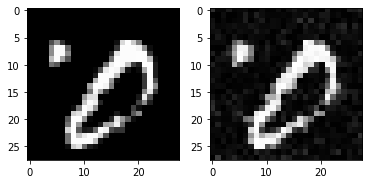

25  :  -0.19889637570799967 25
50  :  0.2891281671030799 25
75  :  0.16138031843883405 25
100  :  0.39709352774765416 25
125  :  0.5327837614697737 25
150  :  0.5872498345884597 25
175  :  0.5931272040935307 25
200  :  0.5932570001740771 25
225  :  0.5932570001740771 25
250  :  0.6105430613411829 25
275  :  0.6198171674943065 25
300  :  0.619806504526168 25
325  :  0.6239534740956125 25
350  :  0.6319487053619903 25
375  :  0.6329591717216225 25
400  :  0.6354408569107173 25
425  :  0.6425792689167708 25
450  :  0.6461583667035227 25
475  :  0.6464214234351149 25
500  :  0.6479910232958674 25
525  :  0.6477704345756838 25
550  :  0.6495128000164766 25
575  :  0.6494632740571515 25
600  :  0.6495539685055249 25
625  :  0.651781446670391 25
650  :  0.651781446670391 25
675  :  0.651781446670391 25
700  :  0.651947855456962 25
725  :  0.6528309762740383 25
750  :  0.653258702116918 25
775  :  0.6543066836970837 25
800  :  0.6543066836970837 25
825  :  0.6544372978620375 25
850  :  0.65443

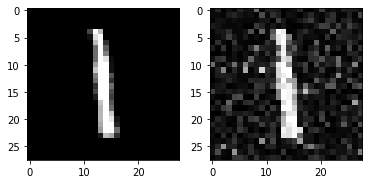

25  :  -0.28061409876157783 25
50  :  -0.28061409876157783 25
75  :  -0.2764365364824785 25
100  :  -0.24118227731838845 25
125  :  -0.0667218843405962 25
150  :  0.29273073667373284 25
175  :  0.5406584959946867 25
200  :  0.5849080402840974 25
225  :  0.5871060670586836 25
250  :  0.6031313672429053 25
275  :  0.6054945766063677 25
300  :  0.6145656540184119 25
325  :  0.6229533625052628 25
350  :  0.6254877840579093 25
375  :  0.6373865421518692 25
400  :  0.6379074563195485 25
425  :  0.6403695383451032 25
450  :  0.6462264850061115 25
475  :  0.6479777145698278 25
500  :  0.6490065296746962 25
525  :  0.649454783516386 25
550  :  0.6503959583016848 25
575  :  0.6507563517554327 25
600  :  0.651917668678959 25
625  :  0.6540789494602429 25
650  :  0.6554576025213525 25
675  :  0.6570319546044174 25
700  :  0.6582576816842802 25
725  :  0.6583048354552978 25
750  :  0.6587901315898091 25
775  :  0.6594721025509953 25
800  :  0.6597399818279892 25
825  :  0.6599303818948735 25
850  :

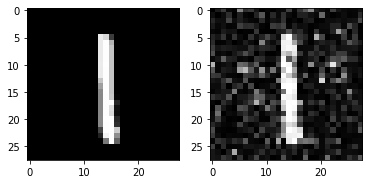

25  :  -0.18214345121545894 25
50  :  0.0975334771826202 25
75  :  0.04371473683857395 25
100  :  0.4207982329274263 25
125  :  0.4733424674836356 25
150  :  0.5866444333562416 25
175  :  0.5964680601481178 25
200  :  0.6042880381117179 25
225  :  0.6042880381117179 25
250  :  0.6079449291617751 25
275  :  0.6091334389403457 25
300  :  0.6143497818361503 25
325  :  0.6157887330722894 25
350  :  0.6171126749884437 25
375  :  0.6172931010018081 25
400  :  0.6195356787906109 25
425  :  0.620840302588383 25
450  :  0.620840302588383 25
475  :  0.6220086282925112 25
500  :  0.6259322534180842 25
525  :  0.6259322534180842 25
550  :  0.6259322534180842 25
575  :  0.6259322534180842 25
600  :  0.626380226346932 25
625  :  0.6264304993988219 25
650  :  0.627429072305002 25
675  :  0.6279139881665345 25
700  :  0.6279147630269166 25
725  :  0.6283972114689891 25
750  :  0.6285060966404589 25
775  :  0.6288898076278733 25
800  :  0.6290335208133485 25
825  :  0.6291867801222897 25
850  :  0.6294

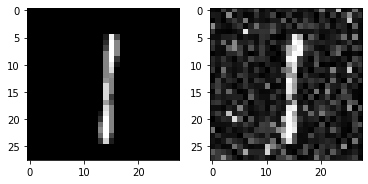

25  :  -0.28788535110097435 25
50  :  -0.2864445952447441 25
75  :  -0.2864480036302872 25
100  :  -0.2864480036302872 25
125  :  -0.2864480036302872 25
150  :  -0.2864480036302872 25
175  :  -0.28618297306571316 25
200  :  -0.28622487342749964 25
225  :  -0.28622487342749964 25
250  :  -0.28622487342749964 25
275  :  -0.2860842103813695 25
300  :  -0.2859252940809057 25
325  :  -0.2859407394548612 25
350  :  -0.2859407394548612 25
375  :  -0.285527388147149 25
400  :  -0.2855097643945398 25
425  :  -0.28554691186860215 25
450  :  -0.28552884983461985 25
475  :  -0.28552884983461985 25
500  :  -0.2854427006161817 25
525  :  -0.2853179821336913 25
550  :  -0.28515198532029523 25
575  :  -0.2851212768450348 25
600  :  -0.285130844470743 25
625  :  -0.2851091530604477 25
650  :  -0.285130844470743 25
675  :  -0.285130844470743 25
700  :  -0.2849223471955662 25
725  :  -0.2848747240466026 25
750  :  -0.28483852367472173 25
775  :  -0.2847962124315519 25
800  :  -0.28476620207727865 25
Time

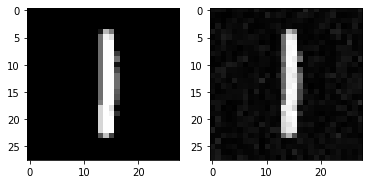

25  :  -0.06071640673387735 25
50  :  -0.06071640673387735 25
75  :  0.023046751600904358 25
100  :  0.1371127801362528 25
125  :  0.5547467447233004 25
150  :  0.63814929708182 25
175  :  0.6410628330305406 25
200  :  0.6431284759745162 25
225  :  0.6431284759745162 25
250  :  0.6459255435963267 25
275  :  0.6519262761020039 25
300  :  0.6653324127517137 25
325  :  0.6665726635470136 25
350  :  0.673483252680409 25
375  :  0.674904265972009 25
400  :  0.6752520952883616 25
425  :  0.6826700344860104 25
450  :  0.6826766573994913 25
475  :  0.6861543284077223 25
500  :  0.6861543284077223 25
525  :  0.6866364096008917 25
550  :  0.6868128143865988 25
575  :  0.6882472714101158 25
600  :  0.688566089257641 25
625  :  0.6891960052601951 25
650  :  0.6891936773749963 25
675  :  0.6911625160332352 25
700  :  0.6915088163591264 25
725  :  0.6923114513967542 25
750  :  0.6922823308135405 25
775  :  0.6923518660111432 25
800  :  0.6928612477542231 25
825  :  0.6932864122745322 25
850  :  0.69

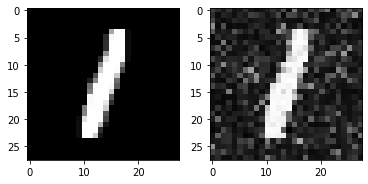

25  :  0.21465683239735486 25
50  :  0.49912085307622134 25
75  :  0.4242761680764345 25
100  :  0.4835173723279498 25
125  :  0.53516750221548 25
150  :  0.5837284001473958 25
175  :  0.5865423714232063 25
200  :  0.6009508013037637 25
225  :  0.6131107670247637 25
250  :  0.6185218118533355 25
275  :  0.634348747606407 25
300  :  0.6359858346743263 25
325  :  0.6404884201979655 25
350  :  0.6406185367442798 25
375  :  0.6470876060879426 25
400  :  0.6498014288239496 25
425  :  0.6512900336859468 25
450  :  0.6526074687769854 25
475  :  0.6562792283509007 25
500  :  0.6562792283509007 25
525  :  0.65728163848979 25
550  :  0.6580894986046324 25
575  :  0.6592890508493664 25
600  :  0.6619453593283369 25
625  :  0.6620366707943095 25
650  :  0.6626429412549152 25
675  :  0.663321305456092 25
700  :  0.665590425692606 25
725  :  0.6658816633488445 25
750  :  0.6670930812071671 25
775  :  0.6681606632127204 25
800  :  0.6692107894263336 25
825  :  0.6692016471285568 25
850  :  0.66988457

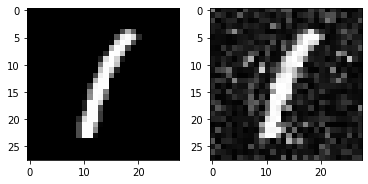

25  :  0.5588239893020743 25
50  :  0.5724686306749116 25
75  :  0.6000066687018591 25
100  :  0.6324349830593712 25
125  :  0.6394472665976428 25
150  :  0.6402638551596854 25
175  :  0.6484448420367505 25
200  :  0.6655226331697913 25
225  :  0.6670403961872547 25
250  :  0.6688290063098035 25
275  :  0.6688290063098035 25
300  :  0.6688290063098035 25
325  :  0.6728284114370339 25
350  :  0.6728284114370339 25
375  :  0.6728284114370339 25
400  :  0.6772232269429536 25
425  :  0.6840361052810184 25
450  :  0.6867680796999627 25
475  :  0.68852656127523 25
500  :  0.6880963967518657 25
525  :  0.69044505603884 25
550  :  0.6915722646975605 25
575  :  0.6925641362452981 25
600  :  0.6927369579805345 25
625  :  0.6927707161290146 25
650  :  0.6930059663419744 25
675  :  0.693256536915575 25
700  :  0.6934652134801206 25
725  :  0.6939474954137166 25
750  :  0.6940131455933986 25
775  :  0.695217542289647 25
800  :  0.6952171582943001 25
825  :  0.6952171582943001 25
850  :  0.695287438

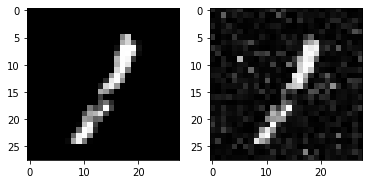

25  :  0.31906320643294506 25
50  :  0.5053211566392496 25
75  :  0.6062438048376221 25
100  :  0.5965680570119971 25
125  :  0.5950727322431297 25
150  :  0.5935595793063678 25
175  :  0.5975482845358423 25
200  :  0.623349859472147 25
225  :  0.6228021216627546 25
250  :  0.6232344244471485 25
275  :  0.6261099497728253 25
300  :  0.6253002447218599 25
325  :  0.6253002447218599 25
350  :  0.6279508530023478 25
375  :  0.6287172819481783 25
400  :  0.6332206712157398 25
425  :  0.6349599916522204 25
450  :  0.6360242217793579 25
475  :  0.6373340220620615 25
500  :  0.6390427980746178 25
525  :  0.6389815969586052 25
550  :  0.6391961412128075 25
575  :  0.6414197996796598 25
600  :  0.6418800933375144 25
625  :  0.6421502612739838 25
650  :  0.642115998190836 25
675  :  0.6426803296252831 25
700  :  0.6428876589287037 25
725  :  0.6434063322395391 25
750  :  0.644957374928945 25
775  :  0.6449302223317406 25
800  :  0.6450652659985494 25
825  :  0.6458089872244631 25
850  :  0.64685

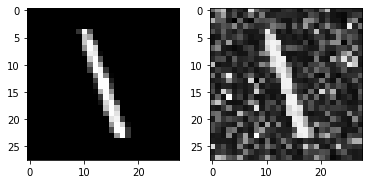

25  :  -0.24569119241610202 25
50  :  0.10971078103756285 25
75  :  -0.010362430916591087 25
100  :  0.2256941426833448 25
125  :  0.40108142281299886 25
150  :  0.5040374956228796 25
175  :  0.5882748343181855 25
200  :  0.5904339018643544 25
225  :  0.5963531697147104 25
250  :  0.6073163845703071 25
275  :  0.608311146439056 25
300  :  0.6106237215862764 25
325  :  0.613284560583239 25
350  :  0.6170357194653547 25
375  :  0.6201550220948068 25
400  :  0.622597079899247 25
425  :  0.6231632397635435 25
450  :  0.6231632397635435 25
475  :  0.6233554251999878 25
500  :  0.627423713399499 25
525  :  0.6280840506650465 25
550  :  0.6290191174561909 25
575  :  0.6294615372540177 25
600  :  0.6319574156529191 25
625  :  0.6334343756406032 25
650  :  0.6333815790036572 25
675  :  0.6351787811035924 25
700  :  0.6359362026481823 25
725  :  0.635743287792262 25
750  :  0.6360998094270864 25
775  :  0.6371844179215875 25
800  :  0.6379731629712423 25
825  :  0.6383223264920411 25
850  :  0.6

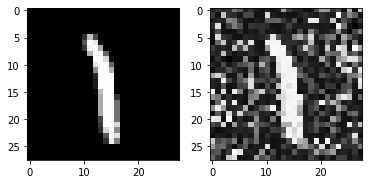

25  :  -0.2981339695171348 25
50  :  -0.2978857235329358 25
75  :  -0.2973202281362667 25
100  :  -0.2964942730090513 25
125  :  -0.29268128649541736 25
150  :  -0.26703907615325606 25
175  :  -0.26596625470683033 25
200  :  -0.20755667058356747 25
225  :  -0.0861855508961302 25
250  :  0.24153265247524416 25
275  :  0.41450559100161743 25
300  :  0.4466247941093806 25
325  :  0.4935651004691119 25
350  :  0.546341281483916 25
375  :  0.54222967681195 25
400  :  0.54222967681195 25
425  :  0.54222967681195 25
450  :  0.5650650181307836 25
475  :  0.57009569198551 25
500  :  0.5772561648075184 25
525  :  0.5835915173061482 25
550  :  0.6055194266704171 25
575  :  0.6055194266704171 25
600  :  0.609933304987631 25
625  :  0.6100021155750323 25
650  :  0.6166592642776805 25
675  :  0.6198662692862237 25
700  :  0.6279981482292896 25
725  :  0.6262168458118103 25
750  :  0.628205129346597 25
775  :  0.6300689586868562 25
800  :  0.6300189753411589 25
825  :  0.6318150750680978 25
850  :  0

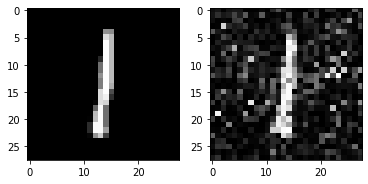

25  :  -0.26202840646717085 25
50  :  -0.2603922078097395 25
75  :  -0.2555823091488765 25
100  :  -0.2470026025269974 25
125  :  0.010684956887608732 25
150  :  0.13502321900001857 25
175  :  0.425162172101629 25
200  :  0.5852673905167628 25
225  :  0.6015889742111262 25
250  :  0.6255979497676836 25
275  :  0.629048900236496 25
300  :  0.629048900236496 25
325  :  0.6353697600468264 25
350  :  0.6409075962243562 25
375  :  0.642231159058756 25
400  :  0.642476360854928 25
425  :  0.6504518817317798 25
450  :  0.6542370497868203 25
475  :  0.6561874656675049 25
500  :  0.6561246416478664 25
525  :  0.6581614393446484 25
550  :  0.6607223654423071 25
575  :  0.6607223654423071 25
600  :  0.6607223654423071 25
625  :  0.661727687946264 25
650  :  0.6641363441465683 25
675  :  0.6646177642869608 25
700  :  0.664951856126849 25
725  :  0.6656584029644044 25
750  :  0.6659359969988508 25
775  :  0.6670258506765856 25
800  :  0.6675372355379798 25
825  :  0.6683173161164202 25
850  :  0.66

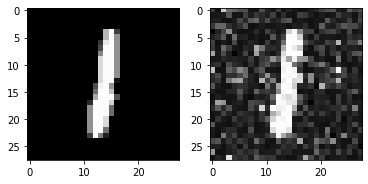

25  :  -0.26190386172134317 25
50  :  -0.25762922432753443 25
75  :  -0.2306648168482226 25
100  :  -0.18637803737644623 25
125  :  0.04265961514919503 25
150  :  0.31686147329740033 25
175  :  0.32864280467036966 25
200  :  0.48273050758369734 25
225  :  0.522243104324323 25
250  :  0.549776892577711 25
275  :  0.5592891199636467 25
300  :  0.5509249953678431 25
325  :  0.5638504033511094 25
350  :  0.5550713386511089 25
375  :  0.5601525764583163 25
400  :  0.5619406174473613 25
425  :  0.5592657551659316 25
450  :  0.5612945984465577 25
475  :  0.5633164052051401 25
500  :  0.5633164052051401 25
525  :  0.5669592230062419 25
550  :  0.5702145943979701 25
575  :  0.5711189281886901 25
600  :  0.5730858646016046 25
625  :  0.5736201438456818 25
650  :  0.5739317943193554 25
675  :  0.5739317943193554 25
700  :  0.5739317943193554 25
725  :  0.5742371624356147 25
750  :  0.5754541604415149 25
775  :  0.576205230734423 25
800  :  0.5763288534683383 25
825  :  0.576715287517545 25
850  :

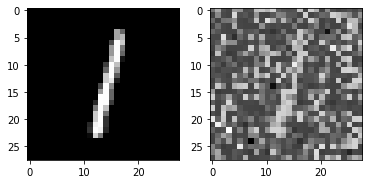

25  :  -0.2607299265115507 25
50  :  -0.2568296179040166 25
75  :  -0.24749746539899553 25
100  :  -0.21733309396133182 25
125  :  -0.0670484508145743 25
150  :  0.07566993323197171 25
175  :  0.5355317270596294 25
200  :  0.5912206533894694 25
225  :  0.6103957724825941 25
250  :  0.6374544825127059 25
275  :  0.6417583727278737 25
300  :  0.6417583727278737 25
325  :  0.6417583727278737 25
350  :  0.6481592834401213 25
375  :  0.6481592834401213 25
400  :  0.6490832985238817 25
425  :  0.6510559134989334 25
450  :  0.6520599364995115 25
475  :  0.6554553120960558 25
500  :  0.6570550090577983 25
525  :  0.6579095029720189 25
550  :  0.6579095029720189 25
575  :  0.661198387904719 25
600  :  0.6623155771031272 25
625  :  0.662859770125455 25
650  :  0.6653061016192625 25
675  :  0.6653061016192625 25
700  :  0.6659066323549736 25
725  :  0.6664432021728863 25
750  :  0.6664432021728863 25
775  :  0.6673296467649787 25
800  :  0.6680427281308385 25
825  :  0.6686309219975446 25
850  : 

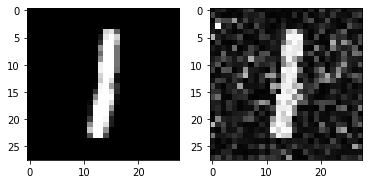

25  :  -0.09019933334494895 25
50  :  0.17137142117367088 25
75  :  0.1094429160847549 25
100  :  0.38972669064570964 25
125  :  0.494734431658965 25
150  :  0.5203826085225752 25
175  :  0.5667488630316886 25
200  :  0.5864409828477887 25
225  :  0.5878169545362059 25
250  :  0.6073714400912473 25
275  :  0.6265180670266546 25
300  :  0.6290573402842247 25
325  :  0.6446479334991004 25
350  :  0.6446479334991004 25
375  :  0.6464066239297619 25
400  :  0.6503379439570318 25
425  :  0.6502843680579049 25
450  :  0.6514895767561159 25
475  :  0.6548900204430033 25
500  :  0.6562071114891936 25
525  :  0.6597415273710704 25
550  :  0.664547973799094 25
575  :  0.6665494759997681 25
600  :  0.6700635813453142 25
625  :  0.6702621899080414 25
650  :  0.6703594301141456 25
675  :  0.6743764124471765 25
700  :  0.6743924154911113 25
725  :  0.6749478458791563 25
750  :  0.6758215791318654 25
775  :  0.6762593163709977 25
800  :  0.6786050854959453 25
825  :  0.6786065555625774 25
850  :  0.6

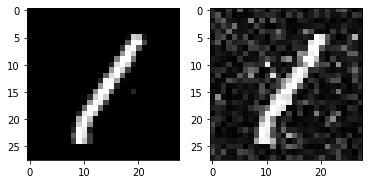

25  :  -0.23322780073437793 25
50  :  -0.23276789512703633 25
75  :  -0.23217062911377223 25
100  :  -0.22995877482737886 25
125  :  -0.22165211507262725 25
150  :  -0.18755283040007345 25
175  :  0.3067096795109281 25
200  :  0.48341544068942394 25
225  :  0.5330689027015738 25
250  :  0.5735076123493572 25
275  :  0.5702134822625449 25
300  :  0.6106305373676582 25
325  :  0.622737341200922 25
350  :  0.6257689644293056 25
375  :  0.6281488600977178 25
400  :  0.627633863822825 25
425  :  0.6418238449414903 25
450  :  0.6473041126511113 25
475  :  0.6531561669460352 25
500  :  0.6531561669460352 25
525  :  0.6531561669460352 25
550  :  0.6531561669460352 25
575  :  0.6573244708137795 25
600  :  0.6580404936739993 25
625  :  0.658235907308582 25
650  :  0.6586022803956912 25
675  :  0.6585964289949222 25
700  :  0.6590680831850321 25
725  :  0.6618506810259629 25
750  :  0.662872139113676 25
775  :  0.6647569702493943 25
800  :  0.6646903363755807 25
825  :  0.6646000390927923 25
850 

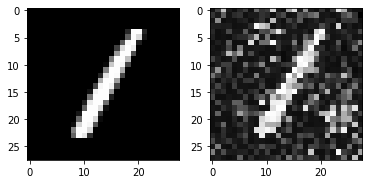

25  :  -0.05312925968220489 25
50  :  0.5629235810915151 25
75  :  -0.06743126722149256 25
100  :  -0.06743126722149256 25
125  :  -0.06743126722149256 25
150  :  -0.06703336312464342 25
175  :  -0.06743126722149256 25
200  :  -0.06743126722149256 25
225  :  -0.0655699290967593 25
250  :  -0.06529740472527512 25
275  :  -0.06478072896123388 25
300  :  -0.06478072896123388 25
325  :  -0.06478072896123388 25
350  :  -0.06478072896123388 25
375  :  -0.06467770892286173 25
400  :  -0.06467902184750385 25
425  :  -0.06467902184750385 25
450  :  -0.064456253894841 25
475  :  -0.06445770617667496 25
500  :  -0.06436355680694544 25
525  :  -0.06438229511782206 25
550  :  -0.06438229511782206 25
575  :  -0.06432644355625194 25
600  :  -0.06429817138296756 25
625  :  -0.06430607371390368 25
650  :  -0.06408515820018196 25
675  :  -0.0640201334970742 25
700  :  -0.0640201334970742 25
725  :  -0.06400376718327572 25
750  :  -0.06396818390711828 25
775  :  -0.06396818390711828 25
800  :  -0.0639055

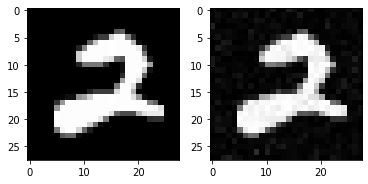

25  :  -0.0773671348052804 25
50  :  -0.07560963597592107 25
75  :  -0.0740892638428115 25
100  :  -0.06736539270073522 25
125  :  -0.06243506409585947 25
150  :  -0.05297012214798419 25
175  :  -0.05401255729585591 25
200  :  0.04084236388587692 25
225  :  0.20815595955812283 25
250  :  0.3722646632183375 25
275  :  0.7122534201599848 25
300  :  0.7082732450842409 25
325  :  0.7190411649580286 25
350  :  0.7070199382431654 25
375  :  0.7070199382431654 25
400  :  0.7076710628585532 25
425  :  0.7211489589497965 25
450  :  0.721449714047154 25
475  :  0.7234962682642497 25
500  :  0.7317511485643597 25
525  :  0.740394415844979 25
550  :  0.75941392428949 25
575  :  0.7574052665050592 25
600  :  0.7574052665050592 25
625  :  0.7579222276193203 25
650  :  0.7590983506716584 25
675  :  0.7605331874843241 25
700  :  0.7627774030984158 25
725  :  0.7668314746393821 25
750  :  0.7681132693066387 25
775  :  0.7684241459439687 25
800  :  0.7684241459439687 25
825  :  0.770112318252804 25
850 

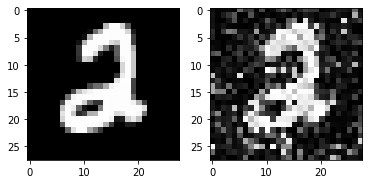

25  :  0.14724078862566126 25
50  :  0.1974058610912347 25
75  :  0.16075322560571598 25
100  :  0.22219941233752621 25
125  :  0.30312207766899085 25
150  :  0.3489741119088076 25
175  :  0.40026871402646047 25
200  :  0.47103828903675077 25
225  :  0.5117870428830629 25
250  :  0.49304432925767294 25
275  :  0.566406153933498 25
300  :  0.5420158932731991 25
325  :  0.5868743012953859 25
350  :  0.6321479154168648 25
375  :  0.6205855370750923 25
400  :  0.6108756382827167 25
425  :  0.6386603840606403 25
450  :  0.6569468454799623 25
475  :  0.6742145543280536 25
500  :  0.7000254433034869 25
525  :  0.6954520778687829 25
550  :  0.6954520778687829 25
575  :  0.6992624411431204 25
600  :  0.7048979437703538 25
625  :  0.7094731278268605 25
650  :  0.7137308916857477 25
675  :  0.7146216853231941 25
700  :  0.7144981909484847 25
725  :  0.7207658171917034 25
750  :  0.7237700173709841 25
775  :  0.7251907137202234 25
800  :  0.7247129860706005 25
825  :  0.7331445285200968 25
850  : 

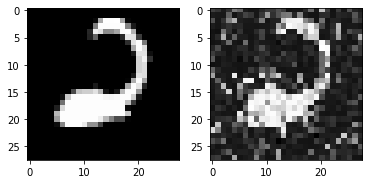

25  :  -0.10060033673874141 25
50  :  -0.10060033673874141 25
75  :  -0.09770897191511935 25
100  :  -0.06487031904065116 25
125  :  -0.059740061917415044 25
150  :  -0.03185504944721734 25
175  :  0.13124090978250036 25
200  :  0.26149533448171186 25
225  :  0.3408685748232376 25
250  :  0.5751842249902507 25
275  :  0.6320265628523666 25
300  :  0.6339642256946677 25
325  :  0.6378666817560034 25
350  :  0.6461340006723175 25
375  :  0.6451918088999746 25
400  :  0.6551802546975569 25
425  :  0.6608501301226419 25
450  :  0.6596129253534502 25
475  :  0.6596129253534502 25
500  :  0.6596129253534502 25
525  :  0.6596129253534502 25
550  :  0.6596129253534502 25
575  :  0.6596129253534502 25
600  :  0.6661430082383213 25
625  :  0.6661430082383213 25
650  :  0.6683550573087541 25
675  :  0.6697231140759627 25
700  :  0.6726012921831956 25
725  :  0.673127591067303 25
750  :  0.6743325222946689 25
775  :  0.6753875187641293 25
800  :  0.6753875187641293 25
825  :  0.6753875187641293 25

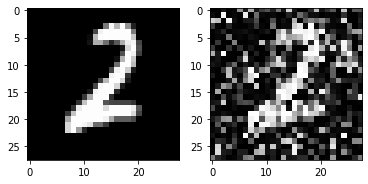

25  :  0.6271290816639288 25
50  :  0.6924830868776586 25
75  :  0.6997651602099846 25
100  :  0.6789261145293883 25
125  :  0.6880869707634752 25
150  :  0.6968687113346204 25
175  :  0.6796287924851725 25
200  :  0.6986137747001621 25
225  :  0.7028490838296149 25
250  :  0.7186786704884904 25
275  :  0.7279488252820938 25
300  :  0.7311455096625779 25
325  :  0.7329057626555536 25
350  :  0.7529691522236586 25
375  :  0.7492090974920531 25
400  :  0.7477487513804957 25
425  :  0.7451376079249108 25
450  :  0.7525923820264595 25
475  :  0.7505415354478466 25
500  :  0.7528373436310412 25
525  :  0.7546365780909876 25
550  :  0.7604207678127078 25
575  :  0.7604207678127078 25
600  :  0.7604207678127078 25
625  :  0.7633192594216167 25
650  :  0.7623333747772374 25
675  :  0.7641889576018769 25
700  :  0.7641889576018769 25
725  :  0.7641889576018769 25
750  :  0.7652852420034757 25
775  :  0.7652827586468758 25
800  :  0.7675158209531566 25
825  :  0.7685719265305524 25
850  :  0.769

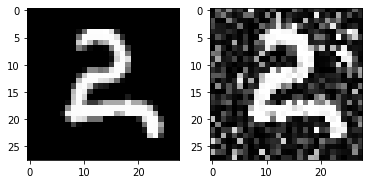

25  :  0.30879334597955255 25
50  :  0.30879334597955255 25
75  :  0.39059943102902833 25
100  :  0.35849640412224854 25
125  :  0.4278084311250462 25
150  :  0.4903018434715709 25
175  :  0.5432175417110328 25
200  :  0.6258440997182279 25
225  :  0.6493681935786195 25
250  :  0.6919620797268438 25
275  :  0.6957012396758953 25
300  :  0.7576621813140252 25
325  :  0.7585578871751475 25
350  :  0.7598482678596293 25
375  :  0.7598482678596293 25
400  :  0.7642712458140462 25
425  :  0.7740718894372141 25
450  :  0.7729603533198275 25
475  :  0.7729603533198275 25
500  :  0.7733881223183368 25
525  :  0.7772072399607669 25
550  :  0.7874286210938799 25
575  :  0.7874233676713527 25
600  :  0.7904324929075037 25
625  :  0.7949068732529208 25
650  :  0.7952588094588164 25
675  :  0.7954387334627862 25
700  :  0.7963847972818532 25
725  :  0.7987623491606958 25
750  :  0.8010515461191099 25
775  :  0.8011738523583503 25
800  :  0.8020111802859956 25
825  :  0.8024580825031054 25
850  :  0

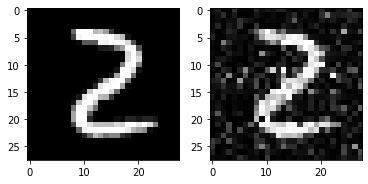

25  :  -0.014737262491220315 25
50  :  0.003952666995818976 25
75  :  -0.0013319241608865107 25
100  :  -0.005041634993669997 25
125  :  0.035555902060977584 25
150  :  0.028684665702764123 25
175  :  0.08122086272635348 25
200  :  0.18961247552772809 25
225  :  0.3670201197059995 25
250  :  0.5828082158409242 25
275  :  0.6571555798288435 25
300  :  0.7410656680372185 25
325  :  0.716876072806556 25
350  :  0.7461950747223505 25
375  :  0.7511013222629557 25
400  :  0.7511013222629557 25
425  :  0.7511013222629557 25
450  :  0.7511013222629557 25
475  :  0.7545915596420918 25
500  :  0.7640320356903018 25
525  :  0.765992170819273 25
550  :  0.7710708062263307 25
575  :  0.7729726488207276 25
600  :  0.7738518634425129 25
625  :  0.7748019095735763 25
650  :  0.7748446551327075 25
675  :  0.7781084776082287 25
700  :  0.7810184756709386 25
725  :  0.7847544624403802 25
750  :  0.7869453963383091 25
775  :  0.7894570384829009 25
800  :  0.7897395235670677 25
825  :  0.791653137502947 2

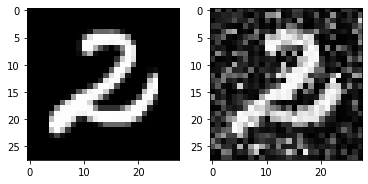

25  :  0.13168542621463808 25
50  :  0.25084859223165357 25
75  :  0.10484432034710528 25
100  :  0.20214155421383412 25
125  :  0.3213228797506723 25
150  :  0.46458137186879805 25
175  :  0.6264727329233827 25
200  :  0.6859086333764658 25
225  :  0.7025239854014896 25
250  :  0.6877782462984917 25
275  :  0.7054417842737319 25
300  :  0.7102345696511206 25
325  :  0.7145044361366282 25
350  :  0.7147986784242504 25
375  :  0.716426586113075 25
400  :  0.7192927458993922 25
425  :  0.7229498241745977 25
450  :  0.7234287935155468 25
475  :  0.7293661054295704 25
500  :  0.7293699975209728 25
525  :  0.7293699975209728 25
550  :  0.7326345563577219 25
575  :  0.7350815856085056 25
600  :  0.7372514201530402 25
625  :  0.7378926385667234 25
650  :  0.7396726052344533 25
675  :  0.7435078218986539 25
700  :  0.7456712812095396 25
725  :  0.7458736595543214 25
750  :  0.7458736595543214 25
775  :  0.7463569185113237 25
800  :  0.7463569185113237 25
825  :  0.7472253169121883 25
850  :  0

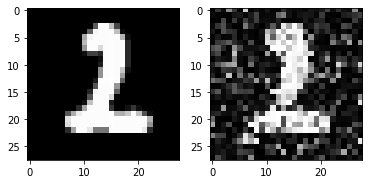

25  :  -0.13497695112676406 25
50  :  -0.13497695112676406 25
75  :  -0.13497695112676406 25
100  :  -0.1339956091783116 25
125  :  -0.1339956091783116 25
150  :  -0.1339956091783116 25
175  :  -0.13278506728426165 25
200  :  -0.13275341676600522 25
225  :  -0.12673919737072947 25
250  :  -0.10320434018097036 25
275  :  -0.0032753084682594635 25
300  :  0.15382956385606933 25
325  :  0.3081874444404047 25
350  :  0.6008967491720529 25
375  :  0.610474773761353 25
400  :  0.6409821971909849 25
425  :  0.656531021302503 25
450  :  0.655169815519639 25
475  :  0.6585216609799671 25
500  :  0.6585216609799671 25
525  :  0.6597609144999423 25
550  :  0.6791395750362345 25
575  :  0.6983429830941077 25
600  :  0.7024456065252458 25
625  :  0.7078743649216439 25
650  :  0.7088735970583222 25
675  :  0.7088735970583222 25
700  :  0.7138480152114283 25
725  :  0.7136520100731742 25
750  :  0.7139501420138813 25
775  :  0.7146136922940388 25
800  :  0.7174393482279046 25
825  :  0.72006222309644

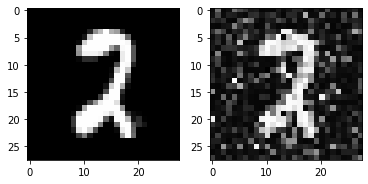

25  :  0.023828046587531626 25
50  :  0.11342257196895611 25
75  :  0.0772764119376167 25
100  :  0.06369591167527422 25
125  :  0.09001264677271906 25
150  :  0.4714972326482827 25
175  :  0.5564419290132113 25
200  :  0.57373340945283 25
225  :  0.6125910892750284 25
250  :  0.6163545603229255 25
275  :  0.6316679641597314 25
300  :  0.6434199794757931 25
325  :  0.650748142933377 25
350  :  0.6575373323131881 25
375  :  0.6635815288184699 25
400  :  0.6758272099204298 25
425  :  0.6788775424971066 25
450  :  0.6900133614363861 25
475  :  0.6929741265420349 25
500  :  0.6957883200144863 25
525  :  0.6960019905007948 25
550  :  0.695768283032654 25
575  :  0.6975480410000413 25
600  :  0.701489233774471 25
625  :  0.7052694537239372 25
650  :  0.7081782001709409 25
675  :  0.7086644364343235 25
700  :  0.7105860527287576 25
725  :  0.7122823951162274 25
750  :  0.7122307490382158 25
775  :  0.7128652128544981 25
800  :  0.7132910154757202 25
825  :  0.7136882286662962 25
850  :  0.714

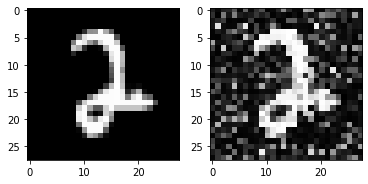

25  :  -0.07388094051457311 25
50  :  -0.012860448803400926 25
75  :  -0.10111597410665163 25
100  :  -0.10111597410665163 25
125  :  -0.10111597410665163 25
150  :  -0.10108173771219442 25
175  :  -0.10111597410665163 25
200  :  -0.09883348571735534 25
225  :  -0.09927813114704154 25
250  :  -0.09778609771904467 25
275  :  -0.09414957954303499 25
300  :  -0.08748900560271083 25
325  :  -0.0489717149128267 25
350  :  0.09679678960734844 25
375  :  0.3498183042939307 25
400  :  0.5582083046065452 25
425  :  0.6238329060951674 25
450  :  0.6309250900528198 25
475  :  0.6313986661012673 25
500  :  0.6535229527091314 25
525  :  0.6530676318707391 25
550  :  0.6695446301959488 25
575  :  0.6789160907379659 25
600  :  0.6832157320322676 25
625  :  0.6825259550790612 25
650  :  0.6865382516540552 25
675  :  0.6882380547788671 25
700  :  0.6899895340693442 25
725  :  0.6908826679238232 25
750  :  0.6938777852225856 25
775  :  0.6960589436184657 25
800  :  0.6961061905179081 25
825  :  0.698259

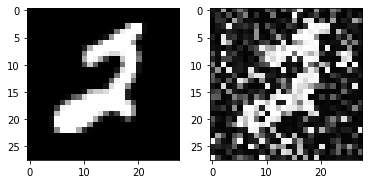

25  :  0.5626331710804677 25
50  :  0.599728119793901 25
75  :  0.6178330765090732 25
100  :  0.5832121090194546 25
125  :  0.5844313071943978 25
150  :  0.5894749481890892 25
175  :  0.6526030870531884 25
200  :  0.6341866102803531 25
225  :  0.7401789223754242 25
250  :  0.7704949237706016 25
275  :  0.7745180142835726 25
300  :  0.7727996101055895 25
325  :  0.8012209495591749 25
350  :  0.8042542511695276 25
375  :  0.8042542511695276 25
400  :  0.8042542511695276 25
425  :  0.8042542511695276 25
450  :  0.8042542511695276 25
475  :  0.8042542511695276 25
500  :  0.8043676610299962 25
525  :  0.8051960257439987 25
550  :  0.8051753167647048 25
575  :  0.8092380968749615 25
600  :  0.8092259928423149 25
625  :  0.8123285405545266 25
650  :  0.8123285405545266 25
675  :  0.8129336991051044 25
700  :  0.8139998741900304 25
725  :  0.8145327672105245 25
750  :  0.8154404642292576 25
775  :  0.8153561176239128 25
800  :  0.8160894767428897 25
825  :  0.8160824457673717 25
850  :  0.8170

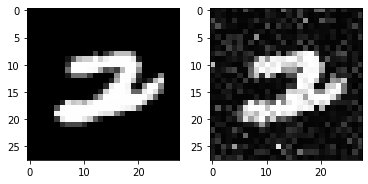

25  :  0.23223395965789878 25
50  :  0.6616407195129757 25
75  :  0.6529195146750759 25
100  :  0.6594472126192941 25
125  :  0.6288416258100992 25
150  :  0.643920983831901 25
175  :  0.6470307429294284 25
200  :  0.675931480813335 25
225  :  0.6760944225266704 25
250  :  0.6760944225266704 25
275  :  0.6767276446681112 25
300  :  0.6851446868781039 25
325  :  0.6889172103783988 25
350  :  0.6900085911871472 25
375  :  0.6918775086827574 25
400  :  0.6939854713929356 25
425  :  0.6939854713929356 25
450  :  0.7051645303465406 25
475  :  0.704567976152583 25
500  :  0.7056947810754971 25
525  :  0.7073839197440024 25
550  :  0.707395610086688 25
575  :  0.7121986940275141 25
600  :  0.7124464963769224 25
625  :  0.7152728581046266 25
650  :  0.7152736837774851 25
675  :  0.7152736837774851 25
700  :  0.7161756397010699 25
725  :  0.7177229056149338 25
750  :  0.7177353437649843 25
775  :  0.7179245536105704 25
800  :  0.7189895626972307 25
825  :  0.719006885023825 25
850  :  0.7205220

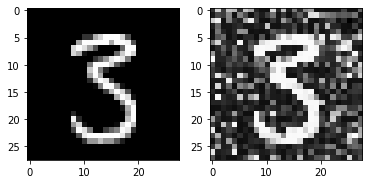

25  :  -0.09189533978390341 25
50  :  -0.030809927737251774 25
75  :  0.04835374066505249 25
100  :  0.10080467390496606 25
125  :  0.2081767147658774 25
150  :  0.2912101450264517 25
175  :  0.1743616076058866 25
200  :  -0.09135048300972581 25
225  :  -0.09178304326153969 25
250  :  -0.09178304326153969 25
275  :  -0.09157391291508526 25
300  :  -0.09144286444626015 25
325  :  -0.09144286444626015 25
350  :  -0.09086338598881821 25
375  :  -0.08963484189177501 25
400  :  -0.09086338598881821 25
425  :  -0.09035842902840746 25
450  :  -0.09054142073822102 25
475  :  -0.0903572363478149 25
500  :  -0.09042400970318054 25
525  :  -0.09034296678831005 25
550  :  -0.09042400970318054 25
575  :  -0.09042400970318054 25
600  :  -0.09042400970318054 25
625  :  -0.09042400970318054 25
650  :  -0.08997634275358768 25
675  :  -0.08997617434745181 25
700  :  -0.08970180369722919 25
725  :  -0.08921032585865646 25
750  :  -0.08881434730240523 25
775  :  -0.0888242997334387 25
800  :  -0.088792768

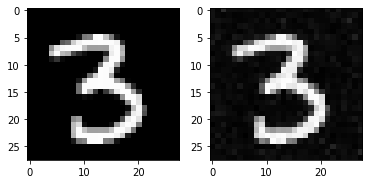

25  :  -0.07531232263274112 25
50  :  0.06350935403193286 25
75  :  -0.07426927829762026 25
100  :  -0.07466381601581479 25
125  :  -0.07465574769432048 25
150  :  -0.07434642743153236 25
175  :  -0.074615147595331 25
200  :  -0.06280032996880897 25
225  :  -0.07396135069449261 25
250  :  -0.07426230232172526 25
275  :  -0.07342109756383397 25
300  :  -0.07361168813926477 25
325  :  -0.07324392828785387 25
350  :  -0.07302052681281612 25
375  :  -0.07253225870846158 25
400  :  -0.07255999237439092 25
425  :  -0.07222533312998719 25
450  :  -0.07222533312998719 25
475  :  -0.07222533312998719 25
500  :  -0.07222533312998719 25
525  :  -0.07222533312998719 25
550  :  -0.07222092735859725 25
575  :  -0.07109940705754925 25
600  :  -0.07124714962861217 25
625  :  -0.07065017264353934 25
650  :  -0.07065017264353934 25
675  :  -0.06853396452989868 25
700  :  -0.06866500106486406 25
725  :  -0.06573702232606615 25
750  :  -0.05951867723156762 25
775  :  -0.05043911387270428 25
800  :  0.0015

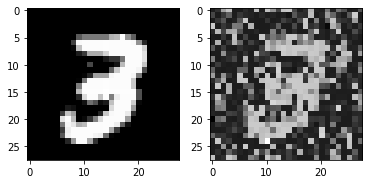

25  :  0.11456284419585955 25
50  :  0.6396690324251602 25
75  :  0.09398671540329495 25
100  :  -0.10020200339323637 25
125  :  0.23016305021100553 25
150  :  0.26063945853400444 25
175  :  -0.10997308412120554 25
200  :  -0.10952071098623595 25
225  :  -0.10793235264012951 25
250  :  -0.10832769576280321 25
275  :  -0.10832769576280321 25
300  :  -0.10832769576280321 25
325  :  -0.10690741440990148 25
350  :  -0.10704926866961006 25
375  :  -0.10704926866961006 25
400  :  -0.10704926866961006 25
425  :  -0.10655664425889388 25
450  :  -0.10648751928424727 25
475  :  -0.10643248140255873 25
500  :  -0.10552804454702275 25
525  :  -0.1056401053426434 25
550  :  -0.1056401053426434 25
575  :  -0.1056279732518885 25
600  :  -0.10500156994097404 25
625  :  -0.10506675947046512 25
650  :  -0.10501806569299466 25
675  :  -0.10506959298149826 25
700  :  -0.10466166266704358 25
725  :  -0.1047304339692064 25
750  :  -0.10435542926419944 25
775  :  -0.10435303520457567 25
800  :  -0.1042185001

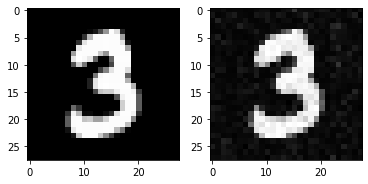

25  :  0.09424848815011 25
50  :  0.5740266304411362 25
75  :  0.26274733024958474 25
100  :  0.3615581749370391 25
125  :  0.41693452669089237 25
150  :  0.4646744115341464 25
175  :  0.34087370805356937 25
200  :  0.3315013666301549 25
225  :  -0.0994063570890385 25
250  :  0.1923832888133844 25
275  :  0.10551172426624938 25
300  :  0.004014641750922532 25
325  :  -0.09907857486496519 25
350  :  -0.09907857486496519 25
375  :  -0.09856547579554531 25
400  :  -0.09856547579554531 25
425  :  -0.09851202282051558 25
450  :  -0.09776103197120684 25
475  :  -0.09780041625594504 25
500  :  -0.09780041625594504 25
525  :  -0.09741992232119073 25
550  :  -0.0974045293141877 25
575  :  -0.09740360521987407 25
600  :  -0.09701912816692859 25
625  :  -0.09634581279469667 25
650  :  -0.09563986379722356 25
675  :  -0.09550974490681374 25
700  :  -0.094827788308391 25
725  :  -0.09460354791459669 25
750  :  -0.09463441779839438 25
775  :  -0.09444765399395832 25
800  :  -0.09377793833809878 25
8

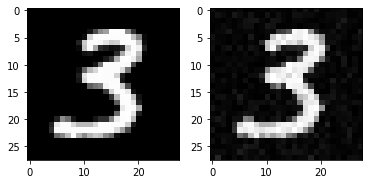

25  :  -0.14297052968215945 25
50  :  -0.14241274402302762 25
75  :  -0.1423003704501194 25
100  :  -0.1409697077156365 25
125  :  -0.14013765532157285 25
150  :  -0.14058755295610692 25
175  :  -0.14058755295610692 25
200  :  -0.14058755295610692 25
225  :  -0.14058755295610692 25
250  :  -0.14058755295610692 25
275  :  -0.14058755295610692 25
300  :  -0.14058755295610692 25
325  :  -0.14058755295610692 25
350  :  -0.14056508739202495 25
375  :  -0.14009191685465544 25
400  :  -0.14001611570720818 25
425  :  -0.13970187242876708 25
450  :  -0.139348338450773 25
475  :  -0.13948866302103363 25
500  :  -0.13938025770546753 25
525  :  -0.13876605759592386 25
550  :  -0.13878219550374293 25
575  :  -0.13878219550374293 25
600  :  -0.13878219550374293 25
625  :  -0.13878219550374293 25
650  :  -0.13878219550374293 25
675  :  -0.13845318444080673 25
700  :  -0.13814930382856805 25
725  :  -0.13819431753076666 25
750  :  -0.1381521146288039 25
775  :  -0.13799582602221844 25
800  :  -0.13800

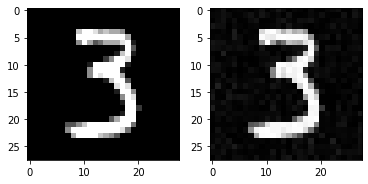

25  :  -0.09796743691853432 25
50  :  -0.09756843170110296 25
75  :  -0.09807216560742871 25
100  :  -0.09628283842520446 25
125  :  -0.09628283842520446 25
150  :  -0.09626741373508668 25
175  :  -0.09628283842520446 25
200  :  -0.09517939679131182 25
225  :  -0.09557471680196955 25
250  :  -0.09529920753094984 25
275  :  -0.09529920753094984 25
300  :  -0.09529920753094984 25
325  :  -0.09480716460794891 25
350  :  -0.09421923246133462 25
375  :  -0.09421923246133462 25
400  :  -0.09421923246133462 25
425  :  -0.09411554084935941 25
450  :  -0.09421923246133462 25
475  :  -0.09421923246133462 25
500  :  -0.09368149183419983 25
525  :  -0.09373916218873202 25
550  :  -0.09373916218873202 25
575  :  -0.09373916218873202 25
600  :  -0.09373916218873202 25
625  :  -0.09342232997388861 25
650  :  -0.09307967804366474 25
675  :  -0.09294905672700243 25
700  :  -0.09235093335499334 25
725  :  -0.09252160181571867 25
750  :  -0.09252160181571867 25
775  :  -0.09252160181571867 25
800  :  -0.

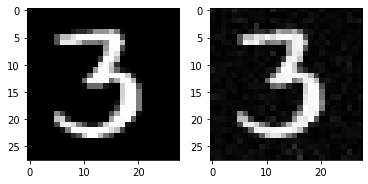

25  :  -0.09120850103974015 25
50  :  -0.09120850103974015 25
75  :  -0.09062651396098631 25
100  :  -0.09054606950392236 25
125  :  -0.09059812443419046 25
150  :  -0.09059812443419046 25
175  :  -0.09059812443419046 25
200  :  -0.09040786162064196 25
225  :  -0.08989217780649883 25
250  :  -0.09005066255578709 25
275  :  -0.08957839925954997 25
300  :  -0.08985446963133598 25
325  :  -0.08985446963133598 25
350  :  -0.08985446963133598 25
375  :  -0.08985446963133598 25
400  :  -0.08985446963133598 25
425  :  -0.0893935500791887 25
450  :  -0.08900473111712304 25
475  :  -0.08900473111712304 25
500  :  -0.08900473111712304 25
525  :  -0.08900473111712304 25
550  :  -0.08879472128184562 25
575  :  -0.08869618373784027 25
600  :  -0.08836628959641496 25
625  :  -0.0881533739376204 25
650  :  -0.0881794211523193 25
675  :  -0.08816068226962209 25
700  :  -0.08799071410579262 25
725  :  -0.08763694037729808 25
750  :  -0.08764034042061863 25
775  :  -0.08760926434401511 25
800  :  -0.087

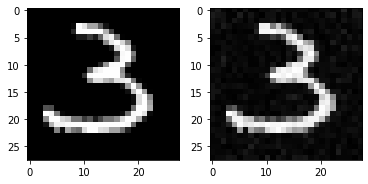

25  :  0.875810745578216 25
50  :  0.8832143939145063 25
75  :  0.8437901737411589 25
100  :  0.8546492065473141 25
125  :  0.8595930916469006 25
150  :  0.851217633303402 25
175  :  0.8677994776932433 25
200  :  0.8709060186874464 25
225  :  0.8754055896443447 25
250  :  0.8831348896419671 25
275  :  0.8817682569936027 25
300  :  0.8837016108828113 25
325  :  0.8873086132577639 25
350  :  0.8880143822477394 25
375  :  0.8880143822477394 25
400  :  0.8886117430777583 25
425  :  0.889782410308859 25
450  :  0.8897578724593735 25
475  :  0.8930363747523788 25
500  :  0.894458874910907 25
525  :  0.895144287664879 25
550  :  0.8990679129090914 25
575  :  0.9002146868100211 25
600  :  0.9018884606503539 25
625  :  0.9016576419597899 25
650  :  0.9016576419597899 25
675  :  0.9020967783548618 25
700  :  0.9028795617556395 25
725  :  0.9028695316875595 25
750  :  0.9032841678751903 25
775  :  0.905103838369565 25
800  :  0.9059172333927995 25
825  :  0.9067641046840673 25
850  :  0.907037439

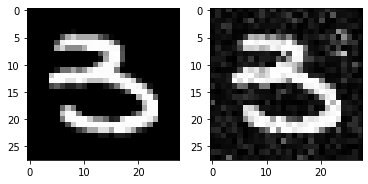

25  :  0.21102901062366175 25
50  :  0.21102901062366175 25
75  :  0.18054111880115414 25
100  :  0.3046638908271508 25
125  :  0.3732064976142001 25
150  :  0.5070753810185644 25
175  :  0.5293669694978731 25
200  :  0.604873888419674 25
225  :  0.663077360706277 25
250  :  0.6889620839281829 25
275  :  0.6827125561333315 25
300  :  0.6827125561333315 25
325  :  0.6827125561333315 25
350  :  0.688702176198513 25
375  :  0.7016474158636063 25
400  :  0.7014610824079042 25
425  :  0.7154546542956095 25
450  :  0.7155872678021645 25
475  :  0.7155872678021645 25
500  :  0.7155872678021645 25
525  :  0.7190314648155602 25
550  :  0.7199891325091488 25
575  :  0.7200474555111456 25
600  :  0.7257757247364298 25
625  :  0.72571055966313 25
650  :  0.7280654255752551 25
675  :  0.7305496100191348 25
700  :  0.7312253703175388 25
725  :  0.7313310056762685 25
750  :  0.7330803195939427 25
775  :  0.7330803195939427 25
800  :  0.7367107169171025 25
825  :  0.7378666659478099 25
850  :  0.73947

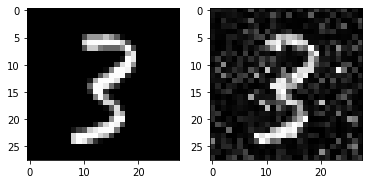

25  :  -0.1297936399454434 25
50  :  -0.12894405870745368 25
75  :  -0.12739948747157592 25
100  :  -0.12716622024886293 25
125  :  -0.12739948747157592 25
150  :  -0.12739948747157592 25
175  :  -0.12739948747157592 25
200  :  -0.12739948747157592 25
225  :  -0.12739948747157592 25
250  :  -0.12686520947076085 25
275  :  -0.1272489950387229 25
300  :  -0.1272489950387229 25
325  :  -0.1266448101755957 25
350  :  -0.12704209729487442 25
375  :  -0.12704209729487442 25
400  :  -0.12681135321674153 25
425  :  -0.12703689466534418 25
450  :  -0.12652634468844032 25
475  :  -0.12659769530898324 25
500  :  -0.126461936882248 25
525  :  -0.12602578191338198 25
550  :  -0.1260340153462119 25
575  :  -0.1260340153462119 25
600  :  -0.12600657967252993 25
625  :  -0.12600657967252993 25
650  :  -0.12581429173038872 25
675  :  -0.1257428928800729 25
700  :  -0.12556487944727662 25
725  :  -0.1255571693549189 25
750  :  -0.1252231667089369 25
775  :  -0.12522978097415755 25
800  :  -0.12498508445

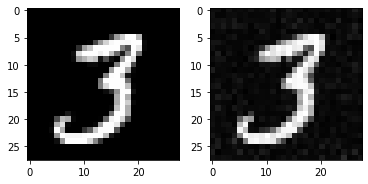

25  :  0.17073314404574935 25
50  :  0.6766181217937127 25
75  :  0.5875373545650062 25
100  :  -0.08564797879058855 25
125  :  -0.08564797879058855 25
150  :  -0.08564797879058855 25
175  :  -0.08564797879058855 25
200  :  0.45749493464472046 25
225  :  -0.08503187937658968 25
250  :  -0.08503187937658968 25
275  :  -0.08277356888940068 25
300  :  -0.08285174708512477 25
325  :  -0.08285174708512477 25
350  :  -0.08285174708512477 25
375  :  -0.08218620439763019 25
400  :  -0.08218620439763019 25
425  :  -0.08218620439763019 25
450  :  -0.08218620439763019 25
475  :  -0.08218620439763019 25
500  :  -0.08218620439763019 25
525  :  -0.08218620439763019 25
550  :  -0.08218620439763019 25
575  :  -0.08218620439763019 25
600  :  -0.08210552140576421 25
625  :  -0.0817823875350921 25
650  :  -0.081943148791913 25
675  :  -0.081943148791913 25
700  :  -0.081943148791913 25
725  :  -0.081943148791913 25
750  :  -0.08185249135341599 25
775  :  -0.08164245866086528 25
800  :  -0.081609926982654

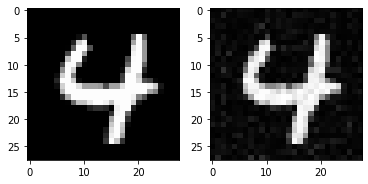

25  :  0.41203846863139754 25
50  :  0.6708781637108114 25
75  :  0.6118686529192139 25
100  :  0.5840756323710736 25
125  :  0.6336489664791698 25
150  :  0.6112600386954383 25
175  :  0.6702051444956278 25
200  :  0.7018500479743853 25
225  :  0.6890475807875127 25
250  :  0.6976139784542775 25
275  :  0.7206623733531805 25
300  :  0.7238676665011686 25
325  :  0.7291574475827751 25
350  :  0.7294835669688866 25
375  :  0.7395381227154023 25
400  :  0.7389756885758745 25
425  :  0.7389756885758745 25
450  :  0.744633273335235 25
475  :  0.7434027802565724 25
500  :  0.7471384399884498 25
525  :  0.753298687315328 25
550  :  0.7535801529310696 25
575  :  0.753682983511733 25
600  :  0.7535997419085092 25
625  :  0.7582078757349573 25
650  :  0.7610199292895687 25
675  :  0.7636102880639587 25
700  :  0.7639046182423299 25
725  :  0.7679829863853201 25
750  :  0.7686316153939994 25
775  :  0.7691158499819708 25
800  :  0.7709897507732391 25
825  :  0.7718758366431129 25
850  :  0.77396

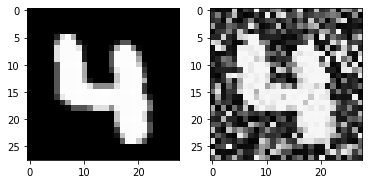

25  :  0.008082052437714593 25
50  :  0.5964685311121323 25
75  :  0.3018695577047411 25
100  :  0.19925509202352296 25
125  :  0.3177221951737278 25
150  :  0.2893063271450459 25
175  :  0.2512811309177979 25
200  :  0.4116978797617833 25
225  :  0.6135599738251075 25
250  :  0.6119254095999301 25
275  :  0.6279697709593255 25
300  :  0.6254869479741688 25
325  :  0.6402584016438886 25
350  :  0.6381443084045524 25
375  :  0.6692286275779104 25
400  :  0.6692286275779104 25
425  :  0.6692286275779104 25
450  :  0.6692286275779104 25
475  :  0.6692286275779104 25
500  :  0.6692286275779104 25
525  :  0.6754060901906012 25
550  :  0.6801033487907098 25
575  :  0.6788039509076526 25
600  :  0.6853032216159275 25
625  :  0.6992228893786111 25
650  :  0.6842818462640873 25
675  :  0.692183393060211 25
700  :  0.6888219889910265 25
725  :  0.6897000373456564 25
750  :  0.6903982628057537 25
775  :  0.6949262883776983 25
800  :  0.6945215977685363 25
825  :  0.6958243680911211 25
850  :  0.6

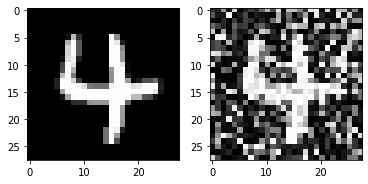

25  :  -0.13831927555430512 25
50  :  0.36135481615017884 25
75  :  0.2684934535434231 25
100  :  0.09004000325334305 25
125  :  0.08581297134665311 25
150  :  0.019368261216129945 25
175  :  0.22197872603547444 25
200  :  0.4810597016754581 25
225  :  0.6171525832242621 25
250  :  0.6373130926488327 25
275  :  0.655703622003855 25
300  :  0.6514365527773129 25
325  :  0.6632283757489674 25
350  :  0.6639029196706322 25
375  :  0.669685282306555 25
400  :  0.6694418518718126 25
425  :  0.6742274437787856 25
450  :  0.6742274437787856 25
475  :  0.6754839820107612 25
500  :  0.675885828401474 25
525  :  0.679781171307924 25
550  :  0.6807573889724075 25
575  :  0.6818532991939834 25
600  :  0.6834213207287002 25
625  :  0.6859007697110195 25
650  :  0.6858189828262845 25
675  :  0.6874106453454614 25
700  :  0.6868312081934279 25
725  :  0.6905829131420467 25
750  :  0.6924883147538449 25
775  :  0.6934193506049345 25
800  :  0.6934193506049345 25
825  :  0.6934193506049345 25
850  :  0

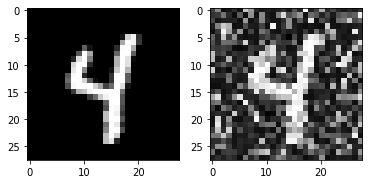

25  :  0.04221531626656477 25
50  :  0.5043407452062167 25
75  :  0.5503459325600252 25
100  :  0.6123298818723157 25
125  :  0.6057666294064297 25
150  :  0.6185030720107569 25
175  :  0.6269123113007851 25
200  :  0.6359318841733628 25
225  :  0.6334312755340727 25
250  :  0.6500938743565372 25
275  :  0.6416176891140228 25
300  :  0.6444938888352889 25
325  :  0.6447930416992677 25
350  :  0.6507109718586966 25
375  :  0.6500497996109458 25
400  :  0.6534458116125231 25
425  :  0.65532813813777 25
450  :  0.6568920828217406 25
475  :  0.6567295073327851 25
500  :  0.661407964346186 25
525  :  0.6677925330689738 25
550  :  0.6663143061748276 25
575  :  0.6663143061748276 25
600  :  0.6663143061748276 25
625  :  0.6666495207763312 25
650  :  0.6666495207763312 25
675  :  0.6671891279578054 25
700  :  0.6683000755598805 25
725  :  0.6701515405408565 25
750  :  0.6710892193401572 25
775  :  0.6716682635467044 25
800  :  0.6718493632034228 25
825  :  0.6727979278505994 25
850  :  0.67336

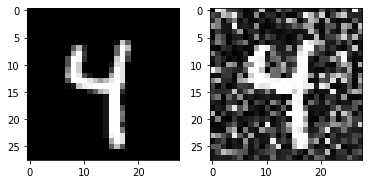

25  :  0.028261742070390505 25
50  :  0.24739972055623646 25
75  :  0.24416827244034298 25
100  :  0.3186704616127193 25
125  :  0.433753498881445 25
150  :  0.38930761703883354 25
175  :  0.41273644612123306 25
200  :  0.5094837926037483 25
225  :  0.5189465446738128 25
250  :  0.5529806384665189 25
275  :  0.587249945633642 25
300  :  0.5729928396102555 25
325  :  0.5974961953276895 25
350  :  0.5962876551121096 25
375  :  0.5962876551121096 25
400  :  0.5964462119296406 25
425  :  0.6038749160127639 25
450  :  0.6038749160127639 25
475  :  0.6038749160127639 25
500  :  0.6038749160127639 25
525  :  0.6052653167138318 25
550  :  0.6274185014756032 25
575  :  0.6318138156879937 25
600  :  0.6415987735397669 25
625  :  0.6426311886688898 25
650  :  0.6562009814829433 25
675  :  0.6566340483662372 25
700  :  0.6655408337545232 25
725  :  0.6651986620061634 25
750  :  0.6734999002011846 25
775  :  0.6792407220481957 25
800  :  0.6859092406880719 25
825  :  0.6898834820312634 25
850  :  0

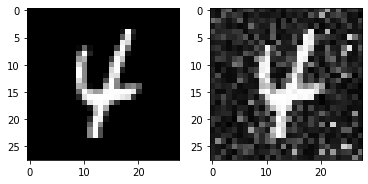

25  :  -0.11393416988595872 25
50  :  -0.11393416988595872 25
75  :  -0.1139300461045149 25
100  :  -0.09380876995557391 25
125  :  -0.08566154630659711 25
150  :  -0.044526279646504796 25
175  :  0.11641453098068877 25
200  :  0.4706454667884724 25
225  :  0.5614199856240343 25
250  :  0.6083125268446045 25
275  :  0.6657095105313464 25
300  :  0.6646073736727662 25
325  :  0.6646073736727662 25
350  :  0.6744414270037343 25
375  :  0.6717298466823722 25
400  :  0.6747134184116425 25
425  :  0.685924602660322 25
450  :  0.6906647481800803 25
475  :  0.6896092672164186 25
500  :  0.6901980441256095 25
525  :  0.7025865239693323 25
550  :  0.6987739630890832 25
575  :  0.7019562902711236 25
600  :  0.7038962659535266 25
625  :  0.706506184763579 25
650  :  0.7140627631043654 25
675  :  0.7142193936304967 25
700  :  0.7141205412375782 25
725  :  0.7168657407236493 25
750  :  0.7177995144180758 25
775  :  0.7181715422598194 25
800  :  0.7188500139658113 25
825  :  0.7188500139658113 25
85

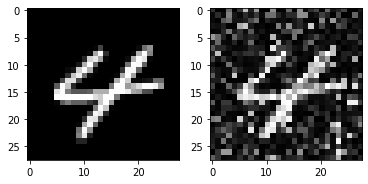

25  :  -0.1312560113432953 25
50  :  -0.1307703359755873 25
75  :  -0.13094373867900766 25
100  :  -0.13094373867900766 25
125  :  -0.13094373867900766 25
150  :  -0.1300935199421393 25
175  :  -0.13010720580385576 25
200  :  -0.13010720580385576 25
225  :  -0.13000401198013456 25
250  :  -0.13000401198013456 25
275  :  -0.12984784477685468 25
300  :  -0.12991301510542047 25
325  :  -0.12910071705345083 25
350  :  -0.12929312402512577 25
375  :  -0.12929312402512577 25
400  :  -0.12904370972442075 25
425  :  -0.1287819308770693 25
450  :  -0.12834958666090346 25
475  :  -0.1283262132319707 25
500  :  -0.12832678609056103 25
525  :  -0.12832678609056103 25
550  :  -0.1281830890872147 25
575  :  -0.12821677638978135 25
600  :  -0.12790165718258462 25
625  :  -0.12747696670469688 25
650  :  -0.12715832022993423 25
675  :  -0.1269304174090774 25
700  :  -0.1269304174090774 25
725  :  -0.12678436916477082 25
750  :  -0.12678436916477082 25
775  :  -0.12650261953620268 25
800  :  -0.12635806

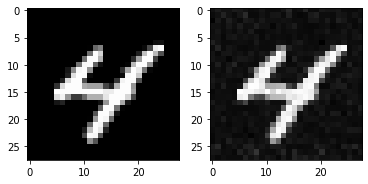

25  :  0.36541142749391226 25
50  :  0.5762824380511242 25
75  :  0.5374255116264448 25
100  :  0.6261650415051779 25
125  :  0.6184425141932295 25
150  :  0.6317008557997915 25
175  :  0.6537242150338767 25
200  :  0.6590091511676877 25
225  :  0.660901868741868 25
250  :  0.6687133018943967 25
275  :  0.6774006206850884 25
300  :  0.6800496909753246 25
325  :  0.6800496909753246 25
350  :  0.683442046706887 25
375  :  0.6847888541790625 25
400  :  0.6870414283110589 25
425  :  0.6873645925655869 25
450  :  0.6874585232246979 25
475  :  0.6881170332612786 25
500  :  0.6900466564462495 25
525  :  0.6913240684370656 25
550  :  0.6922502364125094 25
575  :  0.6932620460460235 25
600  :  0.6935495157922686 25
625  :  0.6946809712131736 25
650  :  0.6959568294098177 25
675  :  0.6976902181429704 25
700  :  0.6975615991231168 25
725  :  0.6975615991231168 25
750  :  0.6975615991231168 25
775  :  0.6979916735621841 25
800  :  0.698271397132247 25
825  :  0.699048714414965 25
850  :  0.699990

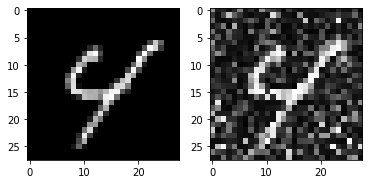

25  :  -0.13848906403470884 25
50  :  0.5545148369478838 25
75  :  0.015761537801985498 25
100  :  0.4394371630526915 25
125  :  0.4139215789005195 25
150  :  0.6045568904492402 25
175  :  0.6214378421285447 25
200  :  0.6011401196638492 25
225  :  0.6149253786338957 25
250  :  0.6279033404607104 25
275  :  0.6506174761262753 25
300  :  0.6525984018184444 25
325  :  0.6637811205050665 25
350  :  0.6689146266562563 25
375  :  0.667307132172134 25
400  :  0.669193980598991 25
425  :  0.6733960929489754 25
450  :  0.6749350486051288 25
475  :  0.6758048859223562 25
500  :  0.676507238400163 25
525  :  0.6777026012676259 25
550  :  0.677859031927587 25
575  :  0.6797585814699149 25
600  :  0.680291460664835 25
625  :  0.680244675618745 25
650  :  0.6807910504885867 25
675  :  0.6811687443391549 25
700  :  0.6810274972166236 25
725  :  0.6812806838397196 25
750  :  0.6813352860674018 25
775  :  0.6818121546076492 25
800  :  0.6820518657308074 25
825  :  0.6822583692548824 25
850  :  0.68253

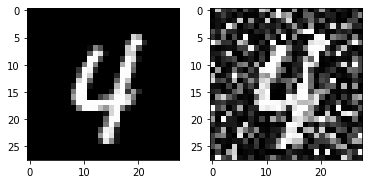

25  :  0.1835141561895316 25
50  :  0.6127034720949546 25
75  :  0.5615104969960059 25
100  :  0.5928594427060707 25
125  :  0.5933952000623589 25
150  :  0.6161685477581417 25
175  :  0.6225849723364866 25
200  :  0.652965306836403 25
225  :  0.644032669896448 25
250  :  0.6504047457829321 25
275  :  0.6554783876351025 25
300  :  0.6787831629268661 25
325  :  0.6797901762762146 25
350  :  0.6815157852645307 25
375  :  0.6792514693340849 25
400  :  0.6832658236998432 25
425  :  0.682508331067059 25
450  :  0.6867972506490574 25
475  :  0.6869446333215234 25
500  :  0.6869446333215234 25
525  :  0.6911263183603853 25
550  :  0.6943654095581273 25
575  :  0.6943654095581273 25
600  :  0.6943654095581273 25
625  :  0.6949573989498092 25
650  :  0.6972613862053484 25
675  :  0.7000439877159459 25
700  :  0.7008788889249083 25
725  :  0.7025488354670666 25
750  :  0.7026749232705845 25
775  :  0.7051773784453143 25
800  :  0.706294476953325 25
825  :  0.7064858761173629 25
850  :  0.7085704

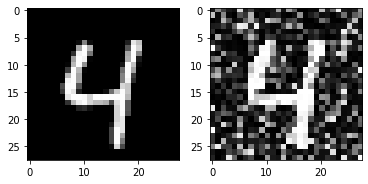

25  :  0.517024087334323 25
50  :  0.6416639994618653 25
75  :  0.6400045733130395 25
100  :  0.6016962082164681 25
125  :  0.625714347581232 25
150  :  0.6330270164101123 25
175  :  0.6472043093180885 25
200  :  0.6504111344303116 25
225  :  0.6590554639844224 25
250  :  0.6586319080023044 25
275  :  0.6608835122220267 25
300  :  0.6646519572858328 25
325  :  0.667967276661063 25
350  :  0.6697635152947646 25
375  :  0.6801996168971687 25
400  :  0.6826855663800151 25
425  :  0.682528026072434 25
450  :  0.682528026072434 25
475  :  0.6832256853058651 25
500  :  0.6839329429696647 25
525  :  0.6843839359049021 25
550  :  0.6840683697273711 25
575  :  0.6865582479643173 25
600  :  0.686008623559388 25
625  :  0.6896106672179397 25
650  :  0.6900952327962153 25
675  :  0.6916985400213684 25
700  :  0.6915531473392313 25
725  :  0.6915826593157093 25
750  :  0.6918253383585294 25
775  :  0.6935391608928623 25
800  :  0.6935388313423715 25
825  :  0.6938505593691806 25
850  :  0.695947502

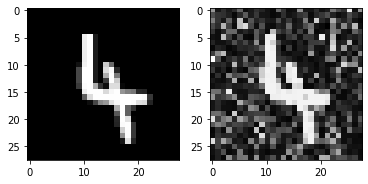

25  :  0.04384806267411803 25
50  :  0.23190266648645316 25
75  :  0.3045273074705095 25
100  :  0.4008047230544923 25
125  :  0.5386473153434846 25
150  :  0.5871214095092308 25
175  :  0.5983287423677512 25
200  :  0.6133259741937858 25
225  :  0.6196871028312396 25
250  :  0.6237084425133439 25
275  :  0.6504556617238952 25
300  :  0.6516970428462657 25
325  :  0.6526412172782616 25
350  :  0.6532512546567938 25
375  :  0.6533273288827824 25
400  :  0.6539184469320108 25
425  :  0.6594785676570057 25
450  :  0.6595009495498605 25
475  :  0.6652102526565029 25
500  :  0.66985470790378 25
525  :  0.6733102637106712 25
550  :  0.6733120062630513 25
575  :  0.6736250429858845 25
600  :  0.6753478245753353 25
625  :  0.6754160750300424 25
650  :  0.6783306901725819 25
675  :  0.6806076217864709 25
700  :  0.680649626748278 25
725  :  0.6813554288897599 25
750  :  0.6826337935316023 25
775  :  0.6827497572924766 25
800  :  0.6827497572924766 25
825  :  0.6833686511359478 25
850  :  0.6833

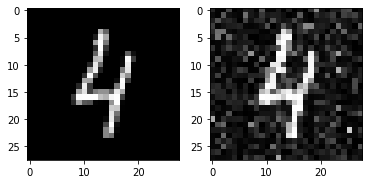

25  :  -0.14654657403840315 25
50  :  -0.14654657403840315 25
75  :  -0.1344919987021992 25
100  :  -0.1002535299744598 25
125  :  -0.044695791663541956 25
150  :  0.0220791798894254 25
175  :  0.1686669910780989 25
200  :  0.2541670599815933 25
225  :  0.37078118088416306 25
250  :  0.4550310006906102 25
275  :  0.45293641072733093 25
300  :  0.45293641072733093 25
325  :  0.45293641072733093 25
350  :  0.4712274646210287 25
375  :  0.4838588809978752 25
400  :  0.49884029436054766 25
425  :  0.5032629298439983 25
450  :  0.5299069566522863 25
475  :  0.5484871698582755 25
500  :  0.5597302948949177 25
525  :  0.5751104952628889 25
550  :  0.5881412775586116 25
575  :  0.5974167332180449 25
600  :  0.6130431855990859 25
625  :  0.6132037049843944 25
650  :  0.6140305002185005 25
675  :  0.6160275610621637 25
700  :  0.6159541224892381 25
725  :  0.6225933509835356 25
750  :  0.6233208672922699 25
775  :  0.6259902511953715 25
800  :  0.6259160667854704 25
825  :  0.6259160667854704 25

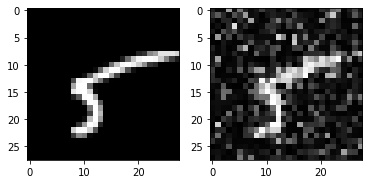

25  :  -0.11028143776608118 25
50  :  -0.090942691662039 25
75  :  -0.08443060759807719 25
100  :  -0.04488789881416333 25
125  :  -0.05435951754839152 25
150  :  0.021972072223757078 25
175  :  0.006163650174343394 25
200  :  0.0159156667574748 25
225  :  0.23141573120586384 25
250  :  0.18791328622448356 25
275  :  0.2827999521260044 25
300  :  0.4819272741999104 25
325  :  0.5714814619380898 25
350  :  0.5712581509881286 25
375  :  0.6163144780538153 25
400  :  0.5799020200306402 25
425  :  0.5759613359963464 25
450  :  0.6190071775755048 25
475  :  0.6612240152254504 25
500  :  0.6542076663764356 25
525  :  0.6580434173115035 25
550  :  0.6732701002930335 25
575  :  0.6788846209520706 25
600  :  0.6741089040114399 25
625  :  0.6780745654202298 25
650  :  0.6921864720720243 25
675  :  0.6942089677909404 25
700  :  0.7022860735936216 25
725  :  0.7000172170603804 25
750  :  0.7003182386169752 25
775  :  0.7045973347428 25
800  :  0.7045973347428 25
825  :  0.7105750392949406 25
850  

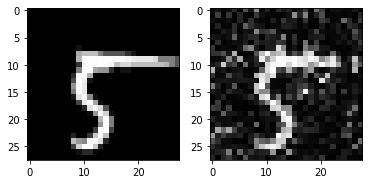

25  :  -0.054922548769457125 25
50  :  -0.05058927080110803 25
75  :  -0.0488324109167137 25
100  :  -0.044572021801175254 25
125  :  -0.038430905805207194 25
150  :  -0.02989479446773169 25
175  :  -0.002918784520502371 25
200  :  0.04976744979773834 25
225  :  0.10697326890492725 25
250  :  0.139141472005476 25
275  :  0.17768213768575347 25
300  :  0.1982926107850448 25
325  :  0.22917364731148565 25
350  :  0.24528597225606458 25
375  :  0.24528597225606458 25
400  :  0.24528597225606458 25
425  :  0.24528597225606458 25
450  :  0.24567411115239923 25
475  :  0.24567411115239923 25
500  :  0.2555151273010565 25
525  :  0.30069568169513144 25
550  :  0.30232091894796176 25
575  :  0.3357591840206694 25
600  :  0.3354156848005009 25
625  :  0.3734197972063283 25
650  :  0.38570163962373116 25
675  :  0.3841390523857381 25
700  :  0.3841390523857381 25
725  :  0.4052867210065278 25
750  :  0.43396232050163863 25
775  :  0.4369683717054918 25
800  :  0.5153339344954709 25
825  :  0.549

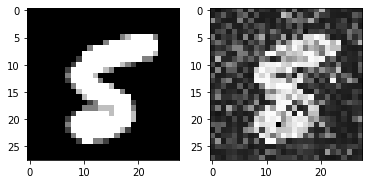

25  :  -0.06933890853229985 25
50  :  -0.06904955415798858 25
75  :  -0.06804598224642422 25
100  :  -0.06804598224642422 25
125  :  -0.06659433840688128 25
150  :  -0.06578987876656844 25
175  :  -0.06576542268124808 25
200  :  -0.06564856635801714 25
225  :  -0.06581602229730799 25
250  :  -0.06581602229730799 25
275  :  -0.0646336990283028 25
300  :  -0.06471098289192062 25
325  :  -0.06457309191195376 25
350  :  -0.06295512130350395 25
375  :  -0.06295512130350395 25
400  :  -0.06182459667745199 25
425  :  -0.06058852498801909 25
450  :  -0.05739684101497439 25
475  :  -0.054357562107497315 25
500  :  -0.043527858049973334 25
525  :  -0.009543274336667629 25
550  :  0.07078558845062721 25
575  :  0.14749492352126753 25
600  :  0.19452360876082891 25
625  :  0.2815561184687896 25
650  :  0.2785610285087189 25
675  :  0.3307804578038095 25
700  :  0.3256963169608998 25
725  :  0.3744194613292676 25
750  :  0.4116025431570416 25
775  :  0.4252052372183095 25
800  :  0.4405146639364045

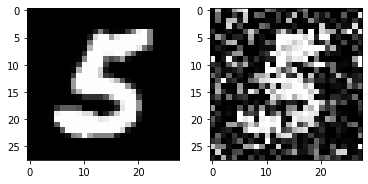

25  :  -0.08085683558191575 25
50  :  -0.07804790422049662 25
75  :  -0.07804790422049662 25
100  :  -0.07759153072651731 25
125  :  -0.077602045931984 25
150  :  -0.07668208434036311 25
175  :  -0.07188026011770371 25
200  :  -0.07191748843945206 25
225  :  -0.07151739675814844 25
250  :  -0.06893679354841076 25
275  :  -0.06201473188753842 25
300  :  -0.05226330794207462 25
325  :  0.01555141450598857 25
350  :  0.09228937051434744 25
375  :  0.19032277725168667 25
400  :  0.32525249613945273 25
425  :  0.3509829587586047 25
450  :  0.36885220950637626 25
475  :  0.38435131284085117 25
500  :  0.4368291054164373 25
525  :  0.4368593940366526 25
550  :  0.49646199000861013 25
575  :  0.5092878903049676 25
600  :  0.5535652754563128 25
625  :  0.5943935761737642 25
650  :  0.5943935761737642 25
675  :  0.6253919827887214 25
700  :  0.6261403618003193 25
725  :  0.6286075389756828 25
750  :  0.6306728777323263 25
775  :  0.650633016611164 25
800  :  0.6541905197341737 25
825  :  0.68245

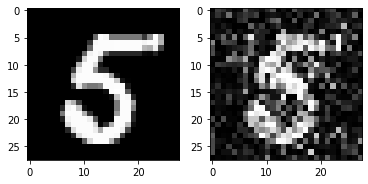

25  :  0.08085782634498384 25
50  :  0.08085782634498384 25
75  :  0.1789727743198874 25
100  :  0.16692575452413877 25
125  :  0.20397703240348786 25
150  :  0.26431667197913283 25
175  :  0.2953092997905068 25
200  :  0.2710908661090851 25
225  :  0.51536593777973 25
250  :  0.6043253706321143 25
275  :  0.6526997520312843 25
300  :  0.6635441093113658 25
325  :  0.700521825766699 25
350  :  0.6866556948802397 25
375  :  0.7026430817172775 25
400  :  0.7116366436055661 25
425  :  0.714977819453275 25
450  :  0.7366056974533366 25
475  :  0.7366056974533366 25
500  :  0.7409106706666919 25
525  :  0.744718747885353 25
550  :  0.7451270380424945 25
575  :  0.7523805874840934 25
600  :  0.7569152313256826 25
625  :  0.7579509879923847 25
650  :  0.7634084505009358 25
675  :  0.7659964231595433 25
700  :  0.766878961312968 25
725  :  0.7671404249849144 25
750  :  0.7671404249849144 25
775  :  0.7694876759902747 25
800  :  0.7722699127281927 25
825  :  0.7762700107717129 25
850  :  0.7767

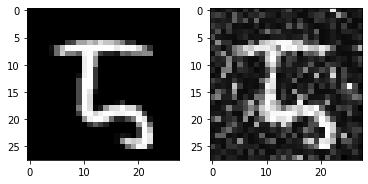

25  :  0.7973062677269134 25
50  :  0.7977687794984853 25
75  :  0.8060096440599784 25
100  :  0.8054004303028013 25
125  :  0.8062153638379881 25
150  :  0.8076930604465193 25
175  :  0.8088369843268726 25
200  :  0.8100307023468057 25
225  :  0.8108146317293827 25
250  :  0.8111058825828659 25
275  :  0.8113153858494737 25
300  :  0.8127210125812798 25
325  :  0.8125697041147053 25
350  :  0.8138903893573811 25
375  :  0.8145412339757578 25
400  :  0.8145412339757578 25
425  :  0.8149877437835837 25
450  :  0.8149698431790275 25
475  :  0.8155078501833333 25
500  :  0.8154644887171303 25
525  :  0.8154644887171303 25
550  :  0.8159166005900031 25
575  :  0.8163162497053678 25
600  :  0.8171916485879283 25
625  :  0.8177486961875904 25
650  :  0.8176813750762254 25
675  :  0.8178328358420224 25
700  :  0.8177947295685966 25
725  :  0.8184270775608965 25
750  :  0.8184047303740096 25
775  :  0.8184047303740096 25
800  :  0.8187230693093446 25
Time:  51.94934391975403  seconds
Predicted

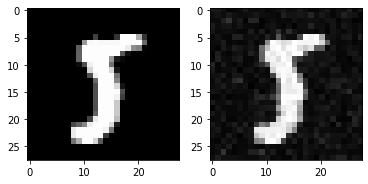

25  :  0.5451313025315561 25
50  :  0.5504030024523023 25
75  :  0.5945470840884999 25
100  :  0.6091363854052638 25
125  :  0.6224052152535393 25
150  :  0.6303934841738232 25
175  :  0.6522913957054135 25
200  :  0.6869717952273231 25
225  :  0.6888141036056119 25
250  :  0.6946931236707345 25
275  :  0.7019597480558657 25
300  :  0.7095223352069154 25
325  :  0.712710834484999 25
350  :  0.7200433350070015 25
375  :  0.7223547867033134 25
400  :  0.7232291178777311 25
425  :  0.7317745831532549 25
450  :  0.7303284088902096 25
475  :  0.7305046801151773 25
500  :  0.7357939904168118 25
525  :  0.7357754503692837 25
550  :  0.7379847756786089 25
575  :  0.7390748686798823 25
600  :  0.739062927044952 25
625  :  0.739062927044952 25
650  :  0.739062927044952 25
675  :  0.7400122177422673 25
700  :  0.7400160421626384 25
725  :  0.7400160421626384 25
750  :  0.7400160421626384 25
775  :  0.7402053303796281 25
800  :  0.7411607568092962 25
825  :  0.7423731696042657 25
850  :  0.7425598

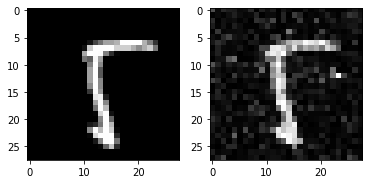

25  :  0.17807825000277216 25
50  :  0.1790954557545132 25
75  :  0.2971692959222279 25
100  :  0.389258550195045 25
125  :  0.5045720615913851 25
150  :  0.5742355043866323 25
175  :  0.7085299731913619 25
200  :  0.7210075864883481 25
225  :  0.7210075864883481 25
250  :  0.7210075864883481 25
275  :  0.7322533831019997 25
300  :  0.7488843335315658 25
325  :  0.7567985591839521 25
350  :  0.7586110179304469 25
375  :  0.7576470465647959 25
400  :  0.7712091387858597 25
425  :  0.7708952585503295 25
450  :  0.7712994119500056 25
475  :  0.7783711930083843 25
500  :  0.779272475729029 25
525  :  0.7791790011430072 25
550  :  0.7791790011430072 25
575  :  0.7822984951224579 25
600  :  0.7823385970792307 25
625  :  0.786118959075599 25
650  :  0.7869735359950285 25
675  :  0.7874997783251062 25
700  :  0.788206002624097 25
725  :  0.7882061083747292 25
750  :  0.789961248004478 25
775  :  0.7911081718473341 25
800  :  0.7911081718473341 25
825  :  0.792602480234188 25
850  :  0.79287247

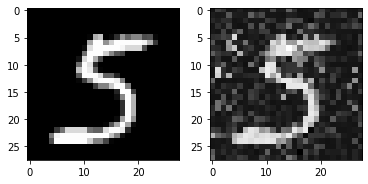

25  :  0.29240103611792856 25
50  :  0.29240103611792856 25
75  :  0.2975353778940586 25
100  :  0.4058873495220929 25
125  :  0.47484490741494373 25
150  :  0.5055421964113426 25
175  :  0.5460130564406827 25
200  :  0.6085936880633275 25
225  :  0.6147401413155472 25
250  :  0.633628490001128 25
275  :  0.6383686240129054 25
300  :  0.652514805368662 25
325  :  0.6908748152813917 25
350  :  0.7173233180314377 25
375  :  0.7307927440336597 25
400  :  0.7355731069674097 25
425  :  0.7715312510640634 25
450  :  0.775270550279595 25
475  :  0.775270550279595 25
500  :  0.775270550279595 25
525  :  0.7790158168102744 25
550  :  0.779051369718592 25
575  :  0.7818800872806799 25
600  :  0.7848888438319669 25
625  :  0.7908130774210942 25
650  :  0.7910367704290389 25
675  :  0.7922534014130254 25
700  :  0.7939891474944354 25
725  :  0.7976799960369971 25
750  :  0.797665987661523 25
775  :  0.7981720854611701 25
800  :  0.800837087634647 25
825  :  0.8014765742163624 25
850  :  0.80314008

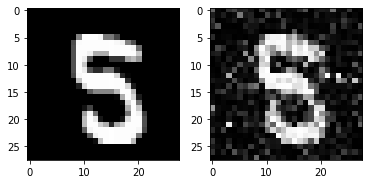

25  :  0.5691800112446597 25
50  :  0.5769571297226823 25
75  :  0.587729810826124 25
100  :  0.5922219621322407 25
125  :  0.6059575202697979 25
150  :  0.6083303680249723 25
175  :  0.6581311584783172 25
200  :  0.680640700632276 25
225  :  0.6899693654615706 25
250  :  0.7065463300146709 25
275  :  0.7087432844973144 25
300  :  0.7138673494236686 25
325  :  0.7183754109492255 25
350  :  0.7216120589346896 25
375  :  0.7242643644628457 25
400  :  0.7243107612303351 25
425  :  0.7243107612303351 25
450  :  0.7281821165692797 25
475  :  0.7290808819204021 25
500  :  0.729404065627082 25
525  :  0.7299306184860266 25
550  :  0.7310766484848412 25
575  :  0.7317408223809452 25
600  :  0.7324592430812555 25
625  :  0.7341208613088779 25
650  :  0.7361422077986848 25
675  :  0.7370795756398728 25
700  :  0.7368842184375751 25
725  :  0.737592775187697 25
750  :  0.7376560509243775 25
775  :  0.7378641199966748 25
800  :  0.737941823854909 25
825  :  0.7385801537427534 25
850  :  0.73889886

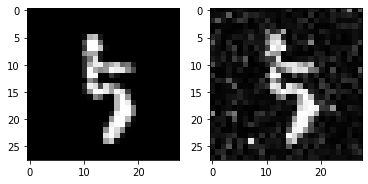

25  :  -0.03352642019511198 25
50  :  -0.02744669826061058 25
75  :  -0.02492618669517982 25
100  :  -0.018884243483282603 25
125  :  -0.002003322861854284 25
150  :  -0.00516265049161313 25
175  :  0.019253718427542754 25
200  :  0.03412585610677321 25
225  :  0.0947660115609344 25
250  :  0.24212483127791884 25
275  :  0.2751110865965735 25
300  :  0.2836854218629931 25
325  :  0.3470428175599268 25
350  :  0.42349871139055645 25
375  :  0.48032140381347754 25
400  :  0.4911024255225477 25
425  :  0.5181645077265723 25
450  :  0.5629444291610701 25
475  :  0.5626084477894311 25
500  :  0.5751573653761717 25
525  :  0.5841040208640039 25
550  :  0.5880123224303765 25
575  :  0.602910390636942 25
600  :  0.6128597945478037 25
625  :  0.6157446128580951 25
650  :  0.6479124777415721 25
675  :  0.6514960504853649 25
700  :  0.6536253796699607 25
725  :  0.6536253796699607 25
750  :  0.6546215765968519 25
775  :  0.6586340409711263 25
800  :  0.6595277809926438 25
825  :  0.66873362332563

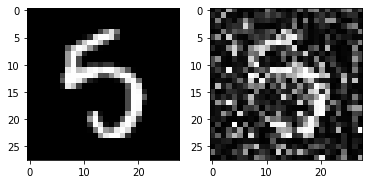

25  :  0.8209589644578056 25
50  :  0.833348206079728 25
75  :  0.8344282929027766 25
100  :  0.8449979075095704 25
125  :  0.8523050001753534 25
150  :  0.8538798633758723 25
175  :  0.8566333366011709 25
200  :  0.8576090104494805 25
225  :  0.8641211996022542 25
250  :  0.8647962483119904 25
275  :  0.8678567134939847 25
300  :  0.8715366296685858 25
325  :  0.8715997995815348 25
350  :  0.871840899435987 25
375  :  0.871840899435987 25
400  :  0.871840899435987 25
425  :  0.8720664688695587 25
450  :  0.8735025929480571 25
475  :  0.8755340245986856 25
500  :  0.8779210361765336 25
525  :  0.877853851067379 25
550  :  0.8779271289363707 25
575  :  0.8803357181951648 25
600  :  0.8803479129201195 25
625  :  0.880393564950477 25
650  :  0.8803930944665084 25
675  :  0.8803930944665084 25
700  :  0.8822353061541368 25
725  :  0.8821480819518221 25
750  :  0.8826201880953409 25
775  :  0.8826621181278308 25
800  :  0.8824298436018752 25
825  :  0.8834125222948824 25
850  :  0.883792696

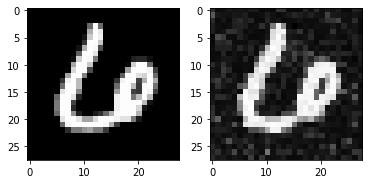

25  :  0.64598092966705 25
50  :  0.6817897766235858 25
75  :  0.6563071703317429 25
100  :  0.6554981533481433 25
125  :  0.671745813819466 25
150  :  0.6812177887930729 25
175  :  0.6947011168191358 25
200  :  0.7069186922970365 25
225  :  0.7085589543204704 25
250  :  0.7067736433129622 25
275  :  0.7131144151202133 25
300  :  0.7252102101190443 25
325  :  0.7321035011179892 25
350  :  0.7342202412441501 25
375  :  0.7364282850718633 25
400  :  0.7364282850718633 25
425  :  0.741418129059896 25
450  :  0.7496748032992162 25
475  :  0.7520297505360717 25
500  :  0.7518527983045538 25
525  :  0.7523058971301377 25
550  :  0.756191807277927 25
575  :  0.7604901939742844 25
600  :  0.7620291052711099 25
625  :  0.7630175607518341 25
650  :  0.763962187015351 25
675  :  0.7690433706643791 25
700  :  0.7700617481790906 25
725  :  0.7710091640663226 25
750  :  0.7743149687729632 25
775  :  0.7743149687729632 25
800  :  0.7747520433272364 25
825  :  0.7766217431219281 25
850  :  0.776753670

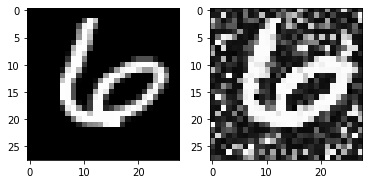

25  :  0.5631502681902671 25
50  :  0.6721150977543262 25
75  :  0.6441169699704212 25
100  :  0.6670833229521816 25
125  :  0.6542431445220398 25
150  :  0.6560414892557097 25
175  :  0.6697005845411979 25
200  :  0.6714128094085847 25
225  :  0.69590289481852 25
250  :  0.6964365901602128 25
275  :  0.7017276804163819 25
300  :  0.7017276804163819 25
325  :  0.7108226448402222 25
350  :  0.7167861615394772 25
375  :  0.7110909022596692 25
400  :  0.7110909022596692 25
425  :  0.7145603562226363 25
450  :  0.7163677789015785 25
475  :  0.7163677789015785 25
500  :  0.7187501241916032 25
525  :  0.7195148799806441 25
550  :  0.7200512619111197 25
575  :  0.7240277684991396 25
600  :  0.7266328293592905 25
625  :  0.727229387455572 25
650  :  0.7300389012775643 25
675  :  0.7300389012775643 25
700  :  0.7300389012775643 25
725  :  0.7314393164132271 25
750  :  0.7330508402763342 25
775  :  0.7329987184257355 25
800  :  0.733379586297326 25
825  :  0.734617377632384 25
850  :  0.73568647

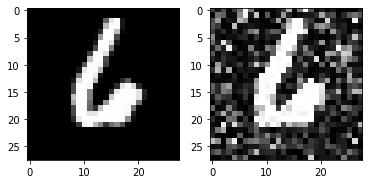

25  :  0.7424077132745561 25
50  :  0.7424077132745561 25
75  :  0.729431506387846 25
100  :  0.7203471449762004 25
125  :  0.7383991727333749 25
150  :  0.7216846766076626 25
175  :  0.7271473510013262 25
200  :  0.7265563879539204 25
225  :  0.7570688832974461 25
250  :  0.7548065158551113 25
275  :  0.7548065158551113 25
300  :  0.7564440615228664 25
325  :  0.7548065158551113 25
350  :  0.7548065158551113 25
375  :  0.7554835591939242 25
400  :  0.7613283146534828 25
425  :  0.7634489183574293 25
450  :  0.7634489183574293 25
475  :  0.7642558785664992 25
500  :  0.7654549117379176 25
525  :  0.7664960457959732 25
550  :  0.7697978002512281 25
575  :  0.7697978002512281 25
600  :  0.7731369988155165 25
625  :  0.7730434946028668 25
650  :  0.7730434946028668 25
675  :  0.7739966052571841 25
700  :  0.7759237562122092 25
725  :  0.7779047186392989 25
750  :  0.7783302070404565 25
775  :  0.7793919454816829 25
800  :  0.779915814572713 25
825  :  0.7813157362763963 25
850  :  0.78333

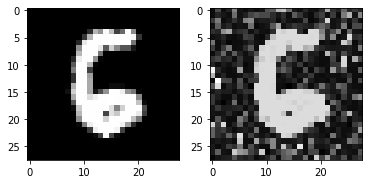

25  :  0.3841500701400676 25
50  :  0.7047203961469967 25
75  :  0.707932051216281 25
100  :  0.7021309101657128 25
125  :  0.6775745905897452 25
150  :  0.6862365195314418 25
175  :  0.6786615965681081 25
200  :  0.6755564088118446 25
225  :  0.6725953334242298 25
250  :  0.6658291884376151 25
275  :  0.6658291884376151 25
300  :  0.6800813042198537 25
325  :  0.6851817638549846 25
350  :  0.7140532629085807 25
375  :  0.7142733952682522 25
400  :  0.7281893293509144 25
425  :  0.7421714004380864 25
450  :  0.7421714004380864 25
475  :  0.7508732809190062 25
500  :  0.7538336439668802 25
525  :  0.7552556622476263 25
550  :  0.7585071452795686 25
575  :  0.7628978893111324 25
600  :  0.7626184771397182 25
625  :  0.7653034777196109 25
650  :  0.7702515983969127 25
675  :  0.7727575308257811 25
700  :  0.7727575308257811 25
725  :  0.7747980308008187 25
750  :  0.7767531629883788 25
775  :  0.7773921896501211 25
800  :  0.7783016557854197 25
825  :  0.7789179188707296 25
850  :  0.7789

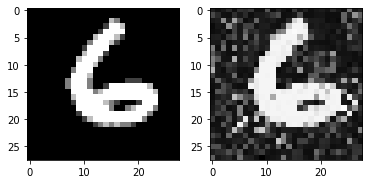

25  :  0.6756010709983239 25
50  :  0.6968174057368158 25
75  :  0.7192764368175066 25
100  :  0.6974531546451034 25
125  :  0.7020620326788221 25
150  :  0.7016828276284138 25
175  :  0.7145136460374032 25
200  :  0.7127361963036727 25
225  :  0.7078777514919878 25
250  :  0.7255176024997978 25
275  :  0.7199934937669354 25
300  :  0.7335689277122245 25
325  :  0.7335555628882207 25
350  :  0.7391471730915655 25
375  :  0.7509950878295553 25
400  :  0.75226901596149 25
425  :  0.7548629636021742 25
450  :  0.7574404963042813 25
475  :  0.7615808818710931 25
500  :  0.7615808818710931 25
525  :  0.7619791480254166 25
550  :  0.7619791480254166 25
575  :  0.7652088914768178 25
600  :  0.7700909068761146 25
625  :  0.7725022008230746 25
650  :  0.7723348349284725 25
675  :  0.7742573217308972 25
700  :  0.7750809334597634 25
725  :  0.7762762478352547 25
750  :  0.7780149426661478 25
775  :  0.7779796752524855 25
800  :  0.7799292778450837 25
825  :  0.7799163546773398 25
850  :  0.78123

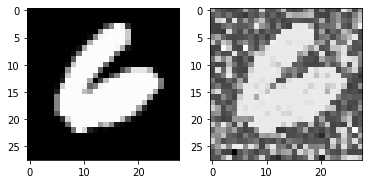

25  :  0.8078743009738464 25
50  :  0.8157056338937891 25
75  :  0.8062126231567288 25
100  :  0.79929034315472 25
125  :  0.7887894717629169 25
150  :  0.7749311534629408 25
175  :  0.7956415575217644 25
200  :  0.8049856401274904 25
225  :  0.8085394039939463 25
250  :  0.8174693540252094 25
275  :  0.8248692294031944 25
300  :  0.8248692294031944 25
325  :  0.8252310131487806 25
350  :  0.8273029896032749 25
375  :  0.8312369985122481 25
400  :  0.8312369985122481 25
425  :  0.8312369985122481 25
450  :  0.8331386202575055 25
475  :  0.8330554303384722 25
500  :  0.8330554303384722 25
525  :  0.8337686403231217 25
550  :  0.8350528372975423 25
575  :  0.8354678380122086 25
600  :  0.8354760959988956 25
625  :  0.83658155805847 25
650  :  0.83658155805847 25
675  :  0.8369185385392786 25
700  :  0.8372870833170188 25
725  :  0.8380702704643861 25
750  :  0.8388387763617915 25
775  :  0.8393906304732612 25
800  :  0.839390600551141 25
825  :  0.839390600551141 25
850  :  0.83939060055

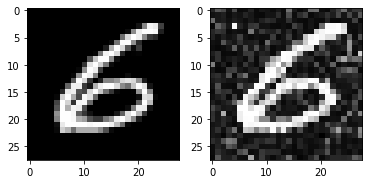

25  :  0.740912163673125 25
50  :  0.740912163673125 25
75  :  0.7042821197857501 25
100  :  0.7105485501130794 25
125  :  0.707335695555688 25
150  :  0.7065348230794157 25
175  :  0.7116292423495805 25
200  :  0.7066888439729505 25
225  :  0.7347680743792522 25
250  :  0.7381072706574431 25
275  :  0.7352939446594373 25
300  :  0.7388660919705119 25
325  :  0.7395563753468102 25
350  :  0.7402940872167796 25
375  :  0.7439329993981552 25
400  :  0.7471880816378514 25
425  :  0.7485327764871827 25
450  :  0.7480643716054856 25
475  :  0.7480643716054856 25
500  :  0.748407015611234 25
525  :  0.7513341031242551 25
550  :  0.7528695061384463 25
575  :  0.752801839597735 25
600  :  0.7536288538953134 25
625  :  0.7536074160576043 25
650  :  0.7548592494997897 25
675  :  0.7549808303462093 25
700  :  0.7561358122480664 25
725  :  0.7560315800021815 25
750  :  0.7561137539899867 25
775  :  0.7581353268846254 25
800  :  0.7581120233789748 25
825  :  0.7588426172879974 25
850  :  0.75959400

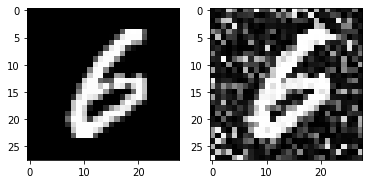

25  :  -0.15326752313390601 25
50  :  0.5819330765836233 25
75  :  -0.09499686244409966 25
100  :  -0.16638599972292661 25
125  :  -0.01494864345013544 25
150  :  -0.14334239823814382 25
175  :  -0.1632450244673937 25
200  :  -0.1632450244673937 25
225  :  -0.1632450244673937 25
250  :  -0.1632450244673937 25
275  :  -0.16070198595045143 25
300  :  -0.16109273098296417 25
325  :  -0.1613576508320504 25
350  :  -0.1610709810517273 25
375  :  -0.1612156443382624 25
400  :  -0.1612156443382624 25
425  :  -0.16115759166730415 25
450  :  -0.1612156443382624 25
475  :  -0.16115864004423602 25
500  :  -0.1596309178652744 25
525  :  -0.16021584583252385 25
550  :  -0.16021584583252385 25
575  :  -0.16021584583252385 25
600  :  -0.16021584583252385 25
625  :  -0.16021584583252385 25
650  :  -0.16001631493511248 25
675  :  -0.15985398888275038 25
700  :  -0.15987100128358783 25
725  :  -0.15974243722338205 25
750  :  -0.15949285352243414 25
775  :  -0.1594621388311806 25
800  :  -0.1594432662089

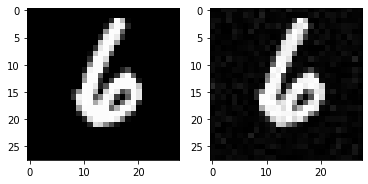

25  :  0.7425275990022201 25
50  :  0.7606066203366597 25
75  :  0.7455144613768261 25
100  :  0.7374432609637207 25
125  :  0.7470629653053962 25
150  :  0.7610909675673849 25
175  :  0.7650815122458138 25
200  :  0.7669210861573739 25
225  :  0.7702616391862144 25
250  :  0.7660490950010862 25
275  :  0.7715570188337046 25
300  :  0.7740694935316046 25
325  :  0.7731798218548771 25
350  :  0.7755598189054664 25
375  :  0.7759971241663475 25
400  :  0.7793725273441059 25
425  :  0.779231320114095 25
450  :  0.7797474375542044 25
475  :  0.7798659995202717 25
500  :  0.7819493844808992 25
525  :  0.7818683439307219 25
550  :  0.7825285407209125 25
575  :  0.7839474813597017 25
600  :  0.7858528544347858 25
625  :  0.7855774971800269 25
650  :  0.785686209764491 25
675  :  0.7880131317278993 25
700  :  0.7885307337056509 25
725  :  0.7894656272318977 25
750  :  0.7898388604351587 25
775  :  0.7919756718608546 25
800  :  0.7924258437461162 25
825  :  0.7923896723669137 25
850  :  0.79448

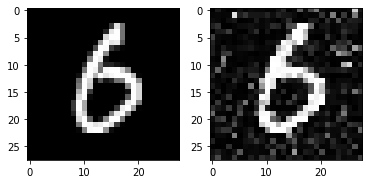

25  :  0.38797569918901537 25
50  :  0.6765887939409765 25
75  :  0.4844494705893499 25
100  :  0.5757576960402233 25
125  :  0.5050169751277942 25
150  :  0.41988697146782694 25
175  :  0.5904716267002411 25
200  :  0.6405294388569119 25
225  :  0.6177284601441422 25
250  :  0.6541650415448202 25
275  :  0.6549357246125538 25
300  :  0.6635125224007965 25
325  :  0.6744424637108142 25
350  :  0.6743347471722344 25
375  :  0.6735431561284249 25
400  :  0.7075149962852278 25
425  :  0.6909815711153853 25
450  :  0.6945485688467707 25
475  :  0.6909815711153853 25
500  :  0.6909815711153853 25
525  :  0.6923800244682765 25
550  :  0.6953845416700959 25
575  :  0.7048446322777645 25
600  :  0.7048384535215341 25
625  :  0.7056408038086681 25
650  :  0.7068781916475463 25
675  :  0.7081789984776521 25
700  :  0.7100038533795658 25
725  :  0.7105697158772596 25
750  :  0.710497398213712 25
775  :  0.712489675861814 25
800  :  0.7123110199517013 25
825  :  0.7123896877461646 25
850  :  0.713

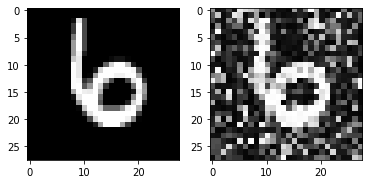

25  :  0.4307565621020938 25
50  :  0.6659387051742565 25
75  :  0.6747763708735639 25
100  :  0.6553265122915701 25
125  :  0.6701928238188647 25
150  :  0.6605612745785179 25
175  :  0.6476835319757452 25
200  :  0.6494342389545201 25
225  :  0.6524554246988078 25
250  :  0.6667966190638667 25
275  :  0.6797985106271727 25
300  :  0.6861304603871096 25
325  :  0.6927330553170544 25
350  :  0.7117766746317808 25
375  :  0.7165311413678037 25
400  :  0.7142318269760008 25
425  :  0.71605683534794 25
450  :  0.7184491293407762 25
475  :  0.7193736898697392 25
500  :  0.7211455312705916 25
525  :  0.7209183914969046 25
550  :  0.7217506805290737 25
575  :  0.7218391860757585 25
600  :  0.7225227446859128 25
625  :  0.7231084831756059 25
650  :  0.7236404019959102 25
675  :  0.7235613213389147 25
700  :  0.7245769468981392 25
725  :  0.7254830711413303 25
750  :  0.7254467902959816 25
775  :  0.7274686177712916 25
800  :  0.7273686091919902 25
825  :  0.7280484612440089 25
850  :  0.72823

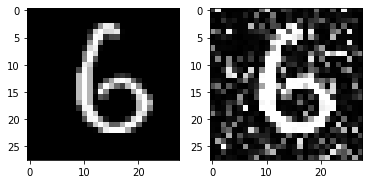

25  :  0.6859638804975144 25
50  :  0.7101518234904944 25
75  :  0.671638404120233 25
100  :  0.685680362642962 25
125  :  0.633570634673501 25
150  :  0.6506275534689339 25
175  :  0.6171745122687863 25
200  :  0.6234446785602382 25
225  :  0.6455418857988346 25
250  :  0.6455418857988346 25
275  :  0.656630711815026 25
300  :  0.6683460304962938 25
325  :  0.6683460304962938 25
350  :  0.6851561691697432 25
375  :  0.6954757523471635 25
400  :  0.6972605677258242 25
425  :  0.7066152991255827 25
450  :  0.7063414787712066 25
475  :  0.7063414787712066 25
500  :  0.7067656750856579 25
525  :  0.7079427601027835 25
550  :  0.7098435560164071 25
575  :  0.7113120477762491 25
600  :  0.7123851851086167 25
625  :  0.7141274665380997 25
650  :  0.7143908575981254 25
675  :  0.7162204066916276 25
700  :  0.7162097205610445 25
725  :  0.7162097205610445 25
750  :  0.7176404974583461 25
775  :  0.7178588404828833 25
800  :  0.7189170892304976 25
825  :  0.7190462246449503 25
850  :  0.7191767

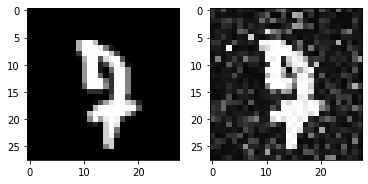

25  :  0.6498446003065805 25
50  :  0.6963468166566944 25
75  :  0.7390233595632199 25
100  :  0.7288754922773879 25
125  :  0.7934166943576002 25
150  :  0.800949935331237 25
175  :  0.8149621442821 25
200  :  0.8026892497679243 25
225  :  0.8117459752577485 25
250  :  0.8184937703604727 25
275  :  0.8392169030609294 25
300  :  0.841129680015667 25
325  :  0.8417997991721229 25
350  :  0.8553057443099557 25
375  :  0.8554344237731986 25
400  :  0.8591897658161519 25
425  :  0.8632827270172323 25
450  :  0.8627512904944364 25
475  :  0.8653250274429525 25
500  :  0.8666481946479235 25
525  :  0.8666481946479235 25
550  :  0.8678806545293327 25
575  :  0.8720251748854746 25
600  :  0.8720251748854746 25
625  :  0.8727208059838514 25
650  :  0.8761940273109515 25
675  :  0.8762702493713834 25
700  :  0.8789739005427784 25
725  :  0.8794592406775226 25
750  :  0.8816803603578014 25
775  :  0.882048850194747 25
800  :  0.8841675786364374 25
825  :  0.8842162491848797 25
850  :  0.884587382

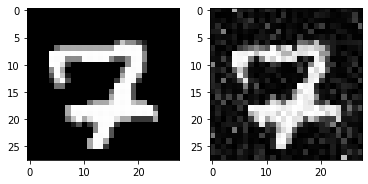

25  :  -0.1009227493504734 25
50  :  0.03367058829404268 25
75  :  0.1966963493470969 25
100  :  0.32679034933502316 25
125  :  0.3506531350700586 25
150  :  0.5833053208385979 25
175  :  0.6958819363189375 25
200  :  0.7135779257789219 25
225  :  0.7310756760463183 25
250  :  0.7310756760463183 25
275  :  0.7310756760463183 25
300  :  0.7354000514586024 25
325  :  0.7435360408386993 25
350  :  0.743139103255188 25
375  :  0.7445057141004581 25
400  :  0.7465983676008632 25
425  :  0.7486655471793784 25
450  :  0.7512255378020911 25
475  :  0.7532161874235971 25
500  :  0.7557529838745431 25
525  :  0.7570876949117535 25
550  :  0.7570876949117535 25
575  :  0.7570876949117535 25
600  :  0.7591675193839384 25
625  :  0.7591680541419148 25
650  :  0.7603755212128449 25
675  :  0.7606493503332787 25
700  :  0.7620846998458244 25
725  :  0.7624702604783666 25
750  :  0.7633038760995976 25
775  :  0.763304040368664 25
800  :  0.7645269624669916 25
825  :  0.7644977490826979 25
850  :  0.76

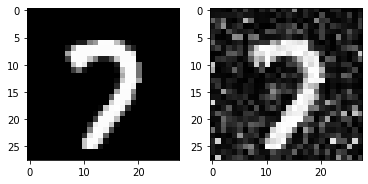

25  :  -0.1719179377550124 25
50  :  0.40040998991983134 25
75  :  -0.16734615554447663 25
100  :  -0.17065796532366367 25
125  :  -0.17070349699699244 25
150  :  -0.17070349699699244 25
175  :  -0.170629931041286 25
200  :  -0.1701360067107054 25
225  :  -0.15238588496170508 25
250  :  -0.1702693322063209 25
275  :  -0.16932206784014753 25
300  :  -0.16876020965812388 25
325  :  -0.16876020965812388 25
350  :  -0.16876020965812388 25
375  :  -0.16864947675786568 25
400  :  -0.16876020965812388 25
425  :  -0.16876020965812388 25
450  :  -0.16784826441550282 25
475  :  -0.16793359036598876 25
500  :  -0.16793359036598876 25
525  :  -0.16793359036598876 25
550  :  -0.16793359036598876 25
575  :  -0.16793359036598876 25
600  :  -0.16793359036598876 25
625  :  -0.1678473299434609 25
650  :  -0.16777531077687308 25
675  :  -0.16777531077687308 25
700  :  -0.16777531077687308 25
725  :  -0.1676898437709447 25
750  :  -0.16753190843183585 25
775  :  -0.167463371416119 25
800  :  -0.1673747012

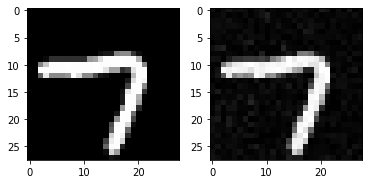

25  :  -0.11705145058367245 25
50  :  -0.04967588411648974 25
75  :  0.005036157464792468 25
100  :  -0.010410941229754389 25
125  :  -0.13374851646217195 25
150  :  -0.13393133547998776 25
175  :  -0.13353004045298472 25
200  :  -0.13349568275301515 25
225  :  -0.13349568275301515 25
250  :  -0.13325173160856796 25
275  :  -0.1326298672706016 25
300  :  -0.1326298672706016 25
325  :  -0.1326298672706016 25
350  :  -0.13214856612242243 25
375  :  -0.13188314132773005 25
400  :  -0.1315555545270949 25
425  :  -0.13163816897880676 25
450  :  -0.13163816897880676 25
475  :  -0.13163816897880676 25
500  :  -0.13143224627046973 25
525  :  -0.13146011869649155 25
550  :  -0.13111189084131702 25
575  :  -0.13111189084131702 25
600  :  -0.13111189084131702 25
625  :  -0.13101448854223674 25
650  :  -0.13068735459951691 25
675  :  -0.1306346350734212 25
700  :  -0.1304686268106574 25
725  :  -0.1303296570005683 25
750  :  -0.13023771192457956 25
775  :  -0.1301740441017437 25
800  :  -0.1299893

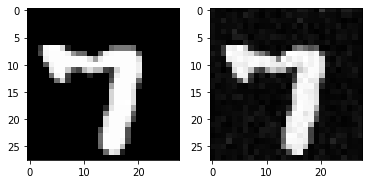

25  :  0.5217744276202324 25
50  :  0.5434852543969932 25
75  :  0.5621579720896569 25
100  :  0.5070168483790759 25
125  :  0.5450034485723905 25
150  :  0.5387914827989106 25
175  :  0.6002450209278613 25
200  :  0.6235988492424651 25
225  :  0.6147245453722012 25
250  :  0.6552413153335899 25
275  :  0.6556576607312412 25
300  :  0.6365651662655668 25
325  :  0.6476465342103109 25
350  :  0.6368161867592176 25
375  :  0.6480063458272312 25
400  :  0.6540691055938904 25
425  :  0.6562579622339415 25
450  :  0.6595642208180073 25
475  :  0.6648202121931506 25
500  :  0.6786671556743358 25
525  :  0.6735586060181675 25
550  :  0.6721318595505539 25
575  :  0.6722321170111998 25
600  :  0.6721318595505539 25
625  :  0.6721318595505539 25
650  :  0.680953513049281 25
675  :  0.6796426708375841 25
700  :  0.6801607943449098 25
725  :  0.6820111924847958 25
750  :  0.6827757280343265 25
775  :  0.6835874032294168 25
800  :  0.6852118631340518 25
825  :  0.6852118631340518 25
850  :  0.6852

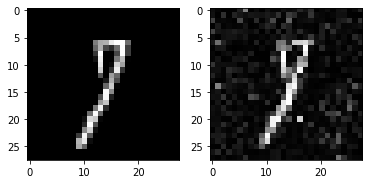

25  :  0.6358417383840917 25
50  :  0.6358417383840917 25
75  :  0.6192409333758029 25
100  :  0.6750225456071937 25
125  :  0.7373486210017559 25
150  :  0.744404923294461 25
175  :  0.7499958137577207 25
200  :  0.7545885127948193 25
225  :  0.7651521296888616 25
250  :  0.7686829981840475 25
275  :  0.7753659645031932 25
300  :  0.7772027263710719 25
325  :  0.7828249495465874 25
350  :  0.7831102191970154 25
375  :  0.7831090844223443 25
400  :  0.7831090844223443 25
425  :  0.7838170402074582 25
450  :  0.7843532277521088 25
475  :  0.7843532277521088 25
500  :  0.7843532277521088 25
525  :  0.7852262787053288 25
550  :  0.7880114545482166 25
575  :  0.7899578126402396 25
600  :  0.7901761552397858 25
625  :  0.7902043234793206 25
650  :  0.7911563063018086 25
675  :  0.7919652984408179 25
700  :  0.7923647670836389 25
725  :  0.7925075315840802 25
750  :  0.7926931574784977 25
775  :  0.7934920706997912 25
800  :  0.794183476636801 25
825  :  0.7951747543896195 25
850  :  0.79596

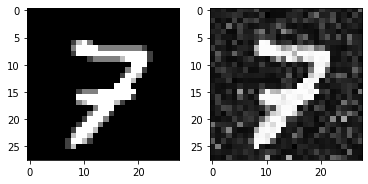

25  :  0.11495734490010168 25
50  :  0.622772839264615 25
75  :  0.5784623706881246 25
100  :  0.6685966953897049 25
125  :  0.6359580511883393 25
150  :  0.664308326893081 25
175  :  0.6833733548135177 25
200  :  0.7079606514679849 25
225  :  0.7202314836148467 25
250  :  0.7194849526683308 25
275  :  0.7234599995240746 25
300  :  0.7234599995240746 25
325  :  0.724711017116767 25
350  :  0.7257683506129701 25
375  :  0.7302854207658964 25
400  :  0.7306226510279947 25
425  :  0.7339735712675238 25
450  :  0.7366455017468807 25
475  :  0.7367920035874009 25
500  :  0.7391206080018382 25
525  :  0.7412003790303987 25
550  :  0.7412309602456731 25
575  :  0.7412207373978532 25
600  :  0.7423092046797913 25
625  :  0.7433956394400495 25
650  :  0.7436440631790436 25
675  :  0.7436166129878055 25
700  :  0.7451731976547837 25
725  :  0.7463790019713148 25
750  :  0.7464260810285941 25
775  :  0.7466446227980363 25
800  :  0.7488348313610103 25
825  :  0.7494285158761087 25
850  :  0.75039

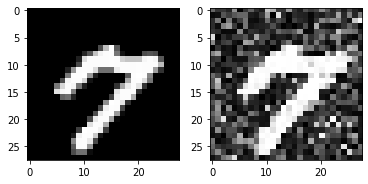

25  :  -0.1515399798606954 25
50  :  -0.1515399798606954 25
75  :  -0.15237854134510698 25
100  :  -0.15237854134510698 25
125  :  -0.15066732110756287 25
150  :  -0.15066732110756287 25
175  :  -0.15066732110756287 25
200  :  -0.15066732110756287 25
225  :  -0.15066732110756287 25
250  :  -0.15066732110756287 25
275  :  -0.15066732110756287 25
300  :  -0.15066732110756287 25
325  :  -0.15000800650021034 25
350  :  -0.1500766287915139 25
375  :  -0.1500766287915139 25
400  :  -0.1500766287915139 25
425  :  -0.14988647238701558 25
450  :  -0.1500766287915139 25
475  :  -0.1489273888322447 25
500  :  -0.1489273888322447 25
525  :  -0.1489273888322447 25
550  :  -0.1489273888322447 25
575  :  -0.14885377282433127 25
600  :  -0.14891441777798647 25
625  :  -0.1489273888322447 25
650  :  -0.1489273888322447 25
675  :  -0.1485804282935459 25
700  :  -0.14823789274715804 25
725  :  -0.1482644331714083 25
750  :  -0.14788660226412453 25
775  :  -0.14788660226412453 25
800  :  -0.14777448759274

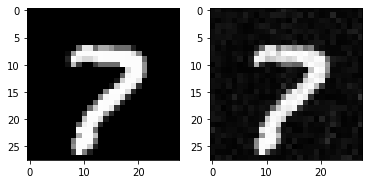

25  :  -0.18080488864124922 25
50  :  -0.1789194872799607 25
75  :  -0.1800814686537912 25
100  :  -0.18005903618814434 25
125  :  -0.1801814475413428 25
150  :  -0.1787368155865212 25
175  :  -0.17849625556526122 25
200  :  -0.17882026368482984 25
225  :  -0.1785576231626833 25
250  :  -0.17917890634567418 25
275  :  -0.17917890634567418 25
300  :  -0.1779794755105505 25
325  :  -0.1779794755105505 25
350  :  -0.1779794755105505 25
375  :  -0.1765492654687001 25
400  :  -0.17743882844212128 25
425  :  -0.17750325121439103 25
450  :  -0.1772381128028861 25
475  :  -0.17684797569552363 25
500  :  -0.17684797569552363 25
525  :  -0.17585447527312165 25
550  :  -0.17516388666365468 25
575  :  -0.1734472378149357 25
600  :  -0.17386226610119426 25
625  :  -0.16775647095428875 25
650  :  -0.12531643695573647 25
675  :  0.024517555564185445 25
700  :  0.31171114363196273 25
725  :  0.42473126678153195 25
750  :  0.5828982467882511 25
775  :  0.572052466710758 25
800  :  0.570880813553919 25


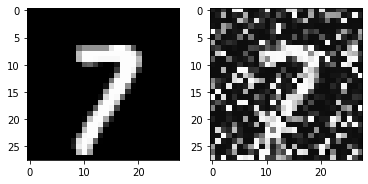

25  :  -0.0031370081493841406 25
50  :  0.13686402556242358 25
75  :  0.3443325980201053 25
100  :  0.3889702420471096 25
125  :  0.5330801348344468 25
150  :  0.6515458028813873 25
175  :  0.6670480932259645 25
200  :  0.67695583965135 25
225  :  0.6769678338541054 25
250  :  0.6769678338541054 25
275  :  0.6831906631525874 25
300  :  0.6851470834835659 25
325  :  0.6862202343184906 25
350  :  0.6915097840866165 25
375  :  0.691795620955346 25
400  :  0.6937843776595272 25
425  :  0.698627346624136 25
450  :  0.6983059686419762 25
475  :  0.6997057423768808 25
500  :  0.7019888109662804 25
525  :  0.7037625777854519 25
550  :  0.7052590228760179 25
575  :  0.705805682904329 25
600  :  0.705768813447599 25
625  :  0.7073328013684155 25
650  :  0.7072973450723733 25
675  :  0.7077143122308882 25
700  :  0.7078077671841053 25
725  :  0.7083026001690216 25
750  :  0.7084713739880713 25
775  :  0.7088103603784708 25
800  :  0.7094550945879611 25
825  :  0.7100013372040236 25
850  :  0.7099

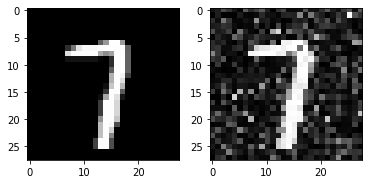

25  :  -0.22149114509755535 25
50  :  -0.22149114509755535 25
75  :  -0.22149114509755535 25
100  :  -0.22149114509755535 25
125  :  -0.22149114509755535 25
150  :  -0.22131917208903717 25
175  :  -0.22149114509755535 25
200  :  -0.22116903064056137 25
225  :  -0.2212998259398301 25
250  :  -0.2212998259398301 25
275  :  -0.22114868584875763 25
300  :  -0.22105110852700455 25
325  :  -0.22027211115637918 25
350  :  -0.22066776063259858 25
375  :  -0.22066989637031736 25
400  :  -0.2199631295504048 25
425  :  -0.21998219265211616 25
450  :  -0.2200205236073286 25
475  :  -0.21937436441506164 25
500  :  -0.21933306662904806 25
525  :  -0.21935700345107934 25
550  :  -0.21842792399726774 25
575  :  -0.21837131000368593 25
600  :  -0.21830312914368455 25
625  :  -0.21731688556504325 25
650  :  -0.21427505689377846 25
675  :  -0.19224833557274573 25
700  :  0.1364269361453024 25
725  :  0.5469496121437969 25
750  :  0.6243438011309418 25
775  :  0.63166320030674 25
800  :  0.632000080934418

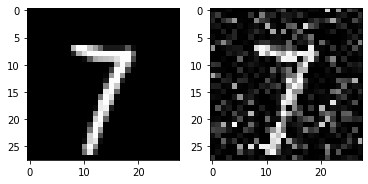

25  :  0.08805040114264703 25
50  :  0.19795054394122022 25
75  :  0.44717975382046393 25
100  :  0.5751587097020593 25
125  :  0.6322230478824984 25
150  :  0.6484949975618146 25
175  :  0.6498063231532886 25
200  :  0.655221564499885 25
225  :  0.655221564499885 25
250  :  0.6578004372084247 25
275  :  0.6589287877278318 25
300  :  0.6612614145390439 25
325  :  0.6613020331297411 25
350  :  0.6613020331297411 25
375  :  0.661912995404038 25
400  :  0.6657629057980039 25
425  :  0.6657629057980039 25
450  :  0.6658823530202622 25
475  :  0.6660545338642976 25
500  :  0.6685345681472199 25
525  :  0.6688482016242591 25
550  :  0.6688384391990903 25
575  :  0.6688384391990903 25
600  :  0.6722178226312739 25
625  :  0.6725292200199352 25
650  :  0.6725447228192641 25
675  :  0.6730459857539557 25
700  :  0.6735055673458441 25
725  :  0.6737384170229799 25
750  :  0.6744394439960064 25
775  :  0.6749595383322261 25
800  :  0.6751033659596071 25
825  :  0.6751750197043235 25
850  :  0.675

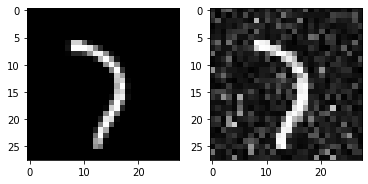

25  :  0.6474266081155093 25
50  :  0.6718644738451245 25
75  :  0.6173446820849273 25
100  :  0.6037661418658057 25
125  :  0.5483409810415514 25
150  :  0.537127801950478 25
175  :  0.6284612965931808 25
200  :  0.6489693659028687 25
225  :  0.34854347158692633 25
250  :  0.018827178450935372 25
275  :  -0.1719493729061815 25
300  :  -0.15319561071157733 25
325  :  -0.0694327800350745 25
350  :  0.024009513312398117 25
375  :  0.6054053690289994 25
400  :  0.6379490537515597 25
425  :  0.652864585909859 25
450  :  0.6578860844160306 25
475  :  0.670142596039023 25
500  :  0.667083157829347 25
525  :  0.6734783065757778 25
550  :  0.6741179078524818 25
575  :  0.6734783065757778 25
600  :  0.6771590890618846 25
625  :  0.6771590890618846 25
650  :  0.6771590890618846 25
675  :  0.6837283520683559 25
700  :  0.687717621711792 25
725  :  0.6871502664481208 25
750  :  0.6890249117736713 25
775  :  0.6916803564167842 25
800  :  0.6919069594477625 25
825  :  0.6941738976839693 25
850  :  0

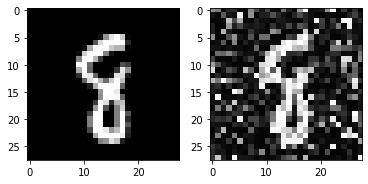

25  :  0.4716357357632265 25
50  :  0.6510418745055159 25
75  :  0.2735424101533741 25
100  :  0.5624971829236945 25
125  :  0.6254527321308969 25
150  :  0.6328352194442955 25
175  :  0.5857869228907318 25
200  :  0.6061361095649501 25
225  :  0.5955911661424417 25
250  :  0.5961197903538297 25
275  :  0.6265000539788425 25
300  :  0.6068103682704369 25
325  :  0.6119359931377104 25
350  :  0.6119359931377104 25
375  :  0.6119359931377104 25
400  :  0.6430943779489342 25
425  :  0.6677107716763644 25
450  :  0.6677107716763644 25
475  :  0.6727274798434569 25
500  :  0.7058894803448252 25
525  :  0.7042826331135545 25
550  :  0.7042826331135545 25
575  :  0.7042826331135545 25
600  :  0.7131313911468276 25
625  :  0.7152700125263101 25
650  :  0.7163727687857879 25
675  :  0.7198189768422396 25
700  :  0.7203671381187854 25
725  :  0.7244468877966447 25
750  :  0.7244468877966447 25
775  :  0.7244468877966447 25
800  :  0.7244468877966447 25
825  :  0.7244468877966447 25
850  :  0.724

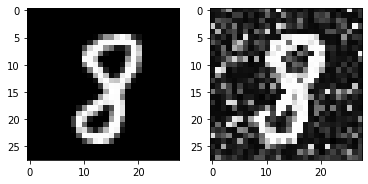

25  :  0.15400290659981591 25
50  :  0.6950796147106802 25
75  :  0.6878437292223438 25
100  :  0.6666398799554888 25
125  :  0.6500113775829203 25
150  :  0.6638619755316366 25
175  :  0.6471844454143292 25
200  :  0.6464287070187581 25
225  :  0.6555709281435884 25
250  :  0.6711636918523031 25
275  :  0.6711636918523031 25
300  :  0.6711636918523031 25
325  :  0.6711636918523031 25
350  :  0.6711636918523031 25
375  :  0.6883410888730732 25
400  :  0.7148187174025133 25
425  :  0.7178681296303933 25
450  :  0.7138487296285538 25
475  :  0.7251182089085281 25
500  :  0.7219957506186689 25
525  :  0.7241524027352017 25
550  :  0.7219957506186689 25
575  :  0.7258230266527275 25
600  :  0.7250655085952171 25
625  :  0.7261661109580033 25
650  :  0.7275164683742699 25
675  :  0.7289871373449321 25
700  :  0.7311168959934704 25
725  :  0.7336928797453698 25
750  :  0.7340970987978097 25
775  :  0.7364131925817929 25
800  :  0.73645593285326 25
825  :  0.73645593285326 25
850  :  0.736455

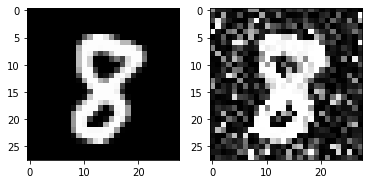

25  :  0.7476344763638856 25
50  :  0.7476344763638856 25
75  :  0.721719752981737 25
100  :  0.7201212889052274 25
125  :  0.7115976859386401 25
150  :  0.7288392362984248 25
175  :  0.7202446536164431 25
200  :  0.7111382284948442 25
225  :  0.6882330071424674 25
250  :  0.7095154074085692 25
275  :  0.7032875108261563 25
300  :  0.7101701838310669 25
325  :  0.7101701838310669 25
350  :  0.7143844929603299 25
375  :  0.7213725788373017 25
400  :  0.7217893645217226 25
425  :  0.7231986430183897 25
450  :  0.7239963824749375 25
475  :  0.7239963824749375 25
500  :  0.7261374638123331 25
525  :  0.7312480121936 25
550  :  0.7299551467585305 25
575  :  0.7299551467585305 25
600  :  0.7300969091908334 25
625  :  0.7317598324128259 25
650  :  0.7335322831681796 25
675  :  0.7341458583834656 25
700  :  0.7342473040362637 25
725  :  0.7365430449063846 25
750  :  0.7371030703521022 25
775  :  0.7381973905753931 25
800  :  0.7387015321964331 25
825  :  0.7391348558235618 25
850  :  0.7390954

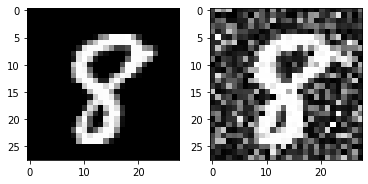

25  :  0.711342600217472 25
50  :  0.735892048427979 25
75  :  0.6911128850915171 25
100  :  0.7024785735790573 25
125  :  0.6892624540614142 25
150  :  0.6904296925527668 25
175  :  0.676837803356793 25
200  :  0.6872969149613787 25
225  :  0.693425613902223 25
250  :  0.6982562150742047 25
275  :  0.7137414854443869 25
300  :  0.7075061967383024 25
325  :  0.7117626358818565 25
350  :  0.7171108805223276 25
375  :  0.7237905610776939 25
400  :  0.720708756396844 25
425  :  0.720708756396844 25
450  :  0.7236114470978584 25
475  :  0.7233302522350602 25
500  :  0.7239669176115011 25
525  :  0.7272929209303161 25
550  :  0.7266748887800978 25
575  :  0.7271269672193119 25
600  :  0.7269701102498544 25
625  :  0.7271915726069089 25
650  :  0.7281467862293775 25
675  :  0.7287407404575328 25
700  :  0.7296124910599754 25
725  :  0.7321344354061877 25
750  :  0.7321958091302846 25
775  :  0.733199263753614 25
800  :  0.7353111740701284 25
825  :  0.7349294394111143 25
850  :  0.7349294394

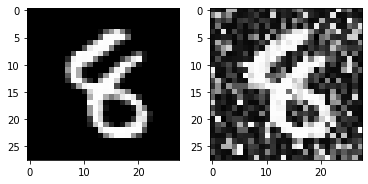

25  :  0.6228481525512927 25
50  :  0.7206282468101722 25
75  :  0.7007722705776092 25
100  :  0.6828797537921178 25
125  :  0.6960557381733546 25
150  :  0.6789232158141596 25
175  :  0.6636840751749449 25
200  :  0.6678592690408679 25
225  :  0.6590428704484935 25
250  :  0.6693846787280219 25
275  :  0.6779693699790933 25
300  :  0.6879364759012626 25
325  :  0.6939795828856969 25
350  :  0.7020811389514029 25
375  :  0.703364971528293 25
400  :  0.7090214283044056 25
425  :  0.7158854776694685 25
450  :  0.7190765923983367 25
475  :  0.731858630089111 25
500  :  0.7274588142717395 25
525  :  0.7296941890606959 25
550  :  0.7296941890606959 25
575  :  0.7333810108477227 25
600  :  0.733235040075325 25
625  :  0.7360536748824824 25
650  :  0.7399761898851667 25
675  :  0.7464857296796401 25
700  :  0.7463555655642871 25
725  :  0.7466909355597071 25
750  :  0.7480748329941416 25
775  :  0.7485851128597912 25
800  :  0.7493705654566578 25
825  :  0.7502632126489395 25
850  :  0.750866

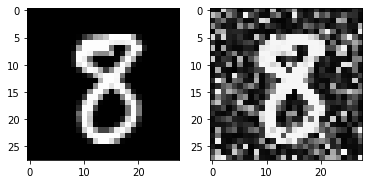

25  :  0.6196135559919291 25
50  :  0.6869488062817108 25
75  :  0.6757201478743856 25
100  :  0.6356377649891339 25
125  :  0.642739673660412 25
150  :  0.6494416975882309 25
175  :  0.6400105564074496 25
200  :  0.640913154887974 25
225  :  0.6802526598940082 25
250  :  0.6771197850583099 25
275  :  0.6771197850583099 25
300  :  0.6858164833793166 25
325  :  0.6894353491430942 25
350  :  0.6891664460886808 25
375  :  0.7012598940023663 25
400  :  0.7107681015409402 25
425  :  0.7137762102450074 25
450  :  0.7143015143308109 25
475  :  0.7143015143308109 25
500  :  0.7194655774465983 25
525  :  0.7192711586738144 25
550  :  0.7210122989145686 25
575  :  0.7233465306681253 25
600  :  0.7254533009249796 25
625  :  0.7252939454177673 25
650  :  0.7276589420331329 25
675  :  0.728815837695449 25
700  :  0.7296503751327501 25
725  :  0.7296551071881271 25
750  :  0.7308776905556007 25
775  :  0.7349756060001567 25
800  :  0.7348122381158734 25
825  :  0.7361795159372377 25
850  :  0.737942

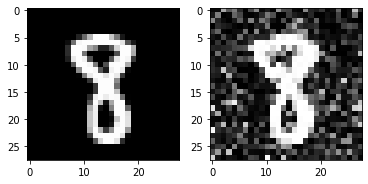

25  :  0.4024974376769492 25
50  :  0.5950657632218698 25
75  :  0.3604052820353378 25
100  :  0.5986952687125932 25
125  :  0.6036132181671676 25
150  :  0.6113243929489786 25
175  :  0.6308312971588773 25
200  :  0.6237858913154446 25
225  :  0.6112754026695744 25
250  :  0.6205677383375653 25
275  :  0.6172355881933436 25
300  :  0.6251419645790897 25
325  :  0.701140003762454 25
350  :  0.6416307513687116 25
375  :  0.6653002783216848 25
400  :  0.6719420659390106 25
425  :  0.6634844451809545 25
450  :  0.6837562430226496 25
475  :  0.6778872144328074 25
500  :  0.6777103845295811 25
525  :  0.6825217717433433 25
550  :  0.6860785981220271 25
575  :  0.6864825616119296 25
600  :  0.6892210575033395 25
625  :  0.6892210575033395 25
650  :  0.6906497266475914 25
675  :  0.6925483305692841 25
700  :  0.69427786292469 25
725  :  0.69427786292469 25
750  :  0.6962799723928825 25
775  :  0.6970826590108913 25
800  :  0.6974986592246338 25
825  :  0.699219619784723 25
850  :  0.700182508

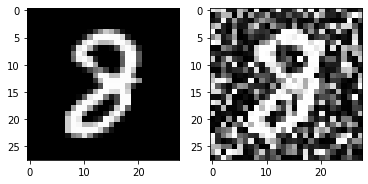

25  :  0.84504530136348 25
50  :  0.85057035834954 25
75  :  0.8299698977834016 25
100  :  0.8237496509265763 25
125  :  0.8218206898493222 25
150  :  0.795635679081736 25
175  :  0.7864825045754441 25
200  :  0.795718139822083 25
225  :  0.8090013645385934 25
250  :  0.8079583088398627 25
275  :  0.8134630865761858 25
300  :  0.8127395074659036 25
325  :  0.8195740005740693 25
350  :  0.8194543927629703 25
375  :  0.8194543927629703 25
400  :  0.8195226782477125 25
425  :  0.8195293798470416 25
450  :  0.8195293798470416 25
475  :  0.820554746548815 25
500  :  0.8223251195252776 25
525  :  0.8236769142031214 25
550  :  0.82422947691005 25
575  :  0.8255717902954933 25
600  :  0.8255710622918655 25
625  :  0.8274366467311824 25
650  :  0.8277794803201122 25
675  :  0.8279110118664086 25
700  :  0.8302065393650115 25
725  :  0.8301219161849878 25
750  :  0.8307850802914322 25
775  :  0.8320098634770274 25
800  :  0.8324068925722852 25
825  :  0.8329460967700931 25
850  :  0.833201877960

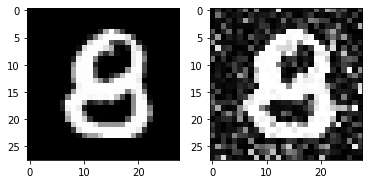

25  :  0.3591945888144949 25
50  :  0.6984318826157441 25
75  :  0.6027197903578322 25
100  :  0.7123224358499884 25
125  :  0.7091907524804166 25
150  :  0.6450163129130784 25
175  :  0.7170419039711998 25
200  :  -0.10566585479415014 25
225  :  -0.10566585479415014 25
250  :  -0.10566585479415014 25
275  :  -0.10517633387724917 25
300  :  -0.10505508936884478 25
325  :  -0.10422150074278358 25
350  :  -0.10338764209879897 25
375  :  -0.10344753422759839 25
400  :  -0.10294898048100054 25
425  :  -0.10196506142408107 25
450  :  -0.10204316425578475 25
475  :  -0.10191546845762073 25
500  :  -0.10153194150288675 25
525  :  -0.10044356447610214 25
550  :  -0.10050633828715216 25
575  :  -0.10041313907398391 25
600  :  -0.10032489118142063 25
625  :  -0.1004392258591989 25
650  :  -0.1004392258591989 25
675  :  -0.1004392258591989 25
700  :  -0.10021820907847068 25
725  :  -0.10000026893699876 25
750  :  -0.09996307667073817 25
775  :  -0.09996307667073817 25
800  :  -0.09996307667073817

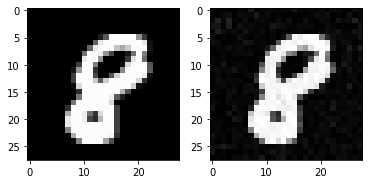

25  :  0.7399808725038008 25
50  :  0.7563829497736407 25
75  :  0.7409385469578442 25
100  :  0.7348630771284045 25
125  :  0.730117540417223 25
150  :  0.7143234073438518 25
175  :  0.7198643436648224 25
200  :  0.7285324013767155 25
225  :  0.7319685465748982 25
250  :  0.7286147945806474 25
275  :  0.7320172111077352 25
300  :  0.7310244242609977 25
325  :  0.7394846647982615 25
350  :  0.7401126123296662 25
375  :  0.7387158064445204 25
400  :  0.7387158064445204 25
425  :  0.7413777039311445 25
450  :  0.7439137035768666 25
475  :  0.7443913276138057 25
500  :  0.7443913276138057 25
525  :  0.744689446435757 25
550  :  0.7463833057993455 25
575  :  0.7470934448913185 25
600  :  0.748211764808018 25
625  :  0.7484325338702276 25
650  :  0.7497966669770031 25
675  :  0.751182233419643 25
700  :  0.7529086269841037 25
725  :  0.7543291458221382 25
750  :  0.7545402071013181 25
775  :  0.756791252509948 25
800  :  0.759464892611452 25
825  :  0.7592914280064134 25
850  :  0.759502021

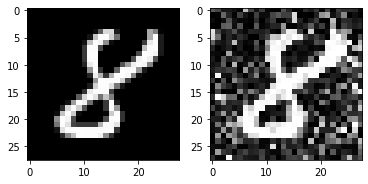

25  :  0.6797675243080712 25
50  :  0.7222375428713466 25
75  :  0.6997557925632845 25
100  :  0.7047170863157046 25
125  :  0.7047873855646377 25
150  :  0.7007327210551315 25
175  :  0.6850087918395309 25
200  :  0.6927696898223836 25
225  :  0.6988259581000803 25
250  :  0.7002628909381747 25
275  :  0.6973530588174157 25
300  :  0.6983793959888464 25
325  :  0.7096784267743634 25
350  :  0.7086474636555955 25
375  :  0.7094910479750602 25
400  :  0.7092864816018227 25
425  :  0.7115878484047388 25
450  :  0.7124673945750276 25
475  :  0.714301022414962 25
500  :  0.7147937404668169 25
525  :  0.7158281198064261 25
550  :  0.7160770129136147 25
575  :  0.7178503262879694 25
600  :  0.7186513747473653 25
625  :  0.720847183279346 25
650  :  0.7211551370722848 25
675  :  0.7241967111380854 25
700  :  0.7242136592025556 25
725  :  0.7240952407620188 25
750  :  0.7259761976539388 25
775  :  0.7257639201755828 25
800  :  0.7283349442701825 25
825  :  0.7298745245637737 25
850  :  0.72947

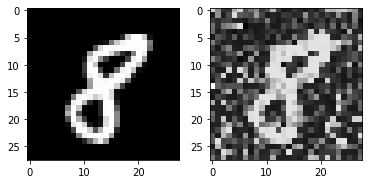

25  :  0.06323959286615749 25
50  :  0.08609988190338136 25
75  :  0.2101046550412936 25
100  :  0.27495589225990824 25
125  :  0.4045466487461449 25
150  :  0.542720544688011 25
175  :  0.5003244854746185 25
200  :  0.6147199490655715 25
225  :  0.6459619926586401 25
250  :  0.6601730135688603 25
275  :  0.6706348640295307 25
300  :  0.6782788486830144 25
325  :  0.678508093733214 25
350  :  0.678508093733214 25
375  :  0.7064486199582778 25
400  :  0.7079396803883092 25
425  :  0.7018108894299536 25
450  :  0.7045102929480234 25
475  :  0.7045102929480234 25
500  :  0.7045102929480234 25
525  :  0.7102415037170362 25
550  :  0.7121088678520553 25
575  :  0.7176645111173885 25
600  :  0.7175421571250638 25
625  :  0.7216368101268501 25
650  :  0.7228579354311686 25
675  :  0.7272423012045315 25
700  :  0.727299818241717 25
725  :  0.727299818241717 25
750  :  0.7278864863745221 25
775  :  0.7278503462638986 25
800  :  0.7282362618420718 25
825  :  0.7308384486539472 25
850  :  0.73082

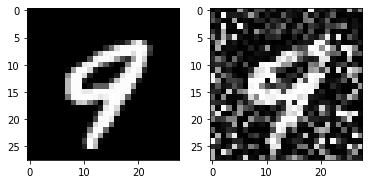

25  :  -0.12286924843540892 25
50  :  -0.12235654833275517 25
75  :  -0.12235654833275517 25
100  :  -0.12045683899221066 25
125  :  -0.12091692109856611 25
150  :  -0.12091692109856611 25
175  :  -0.12091692109856611 25
200  :  -0.11954679070251645 25
225  :  -0.11965096403956288 25
250  :  -0.11918639614892385 25
275  :  -0.11960823793807313 25
300  :  -0.1183503806094498 25
325  :  -0.1183807759793491 25
350  :  -0.11736560422942577 25
375  :  -0.11457706873047457 25
400  :  -0.1111994083549403 25
425  :  -0.11371389663814124 25
450  :  -0.10787703769705281 25
475  :  -0.10413222892578089 25
500  :  -0.08828472602357601 25
525  :  -0.00451457359352081 25
550  :  0.22763599596162787 25
575  :  0.3382369673916198 25
600  :  0.44961889676285804 25
625  :  0.49502264778984806 25
650  :  0.48904734258251104 25
675  :  0.5644345261571719 25
700  :  0.6005709354021974 25
725  :  0.6040076751136081 25
750  :  0.602993748812539 25
775  :  0.6352620887233341 25
800  :  0.636088602730488 25
82

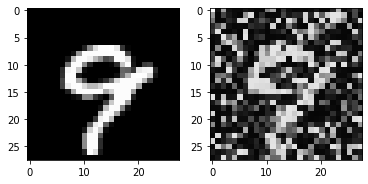

25  :  0.5240738247277161 25
50  :  0.6625084295538961 25
75  :  0.6666741085695486 25
100  :  0.6295896471471761 25
125  :  0.6482905997426631 25
150  :  0.6590263732464142 25
200  :  0.6637431791936728 25
225  :  0.6671278263972025 25
250  :  0.6707443748634117 25
275  :  0.6750901990907735 25
300  :  0.6779519132357457 25
325  :  0.6779519132357457 25
350  :  0.6779519132357457 25
375  :  0.6804140586452015 25
400  :  0.6821459246915454 25
425  :  0.6824830599315146 25
450  :  0.6834171530910923 25
475  :  0.6864141229487164 25
500  :  0.6864141229487164 25
525  :  0.6864141229487164 25
550  :  0.6864141229487164 25
575  :  0.6974264798072614 25
600  :  0.6973898339456789 25
625  :  0.6973898339456789 25
650  :  0.6973898339456789 25
675  :  0.6973898339456789 25
700  :  0.6973898339456789 25
725  :  0.6973898339456789 25
750  :  0.6973898339456789 25
775  :  0.6973898339456789 25
800  :  0.6988682263420132 25
825  :  0.6985673950367874 25
850  :  0.6985673950367874 25
875  :  0.698

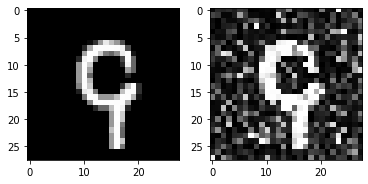

25  :  0.07468029213842603 25
50  :  0.17039515465431593 25
75  :  0.19120151272821656 25
100  :  0.21701684506329555 25
125  :  0.4396695835936787 25
150  :  0.6343080030287793 25
175  :  0.6670721725648727 25
200  :  0.6912439439608864 25
225  :  0.7399915402709374 25
250  :  0.7470494542848756 25
275  :  0.7470494542848756 25
300  :  0.7473789067211254 25
325  :  0.7544216017963313 25
350  :  0.7544216017963313 25
375  :  0.7544216017963313 25
400  :  0.7651711797996493 25
425  :  0.7647560303211927 25
450  :  0.7740432413154249 25
475  :  0.7759433980203267 25
500  :  0.7875717638916149 25
525  :  0.7899860845349211 25
550  :  0.7934321286209062 25
575  :  0.7961301299148813 25
600  :  0.79624692141083 25
625  :  0.7996208368424874 25
650  :  0.7998787991315055 25
675  :  0.8005338607557118 25
700  :  0.8005531006956785 25
725  :  0.8030838976375527 25
750  :  0.8031046802860329 25
775  :  0.8050948125993167 25
800  :  0.8066062986403983 25
825  :  0.8066062986403983 25
850  :  0.8

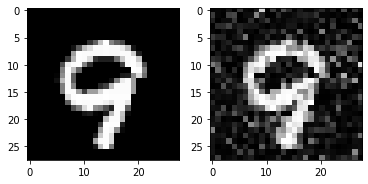

25  :  -0.041371815715349036 25
50  :  -0.011408293428911975 25
75  :  -0.031080848856926968 25
100  :  0.005200463680724465 25
125  :  0.113650448583975 25
150  :  0.16029998141688767 25
175  :  0.4157815014605941 25
200  :  0.6570406411500326 25
225  :  0.6617649653455978 25
250  :  0.6810620245707872 25
275  :  0.6810620245707872 25
300  :  0.6810620245707872 25
325  :  0.6819388946424738 25
350  :  0.6848180200135718 25
375  :  0.6848180200135718 25
400  :  0.6848180200135718 25
425  :  0.6924234366983569 25
450  :  0.6963916345944818 25
475  :  0.6963916345944818 25
500  :  0.6971129328250172 25
525  :  0.7035476098737883 25
550  :  0.7035007428592954 25
575  :  0.7035007428592954 25
600  :  0.7035007428592954 25
625  :  0.7041230267838641 25
650  :  0.7063253878335269 25
675  :  0.7072067921985727 25
700  :  0.7078652439033024 25
725  :  0.7081719088664015 25
750  :  0.7085714678261759 25
775  :  0.7095952559717701 25
800  :  0.7096282886024778 25
825  :  0.7101275610635781 25
85

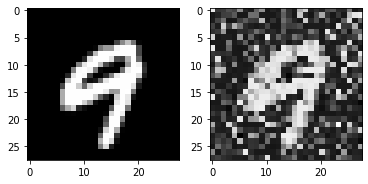

25  :  -0.10199187252293018 25
50  :  -0.10199187252293018 25
75  :  -0.0756661231860552 25
100  :  -0.07281775908203103 25
125  :  -0.03116548907444311 25
150  :  0.047135328816843625 25
175  :  0.41666383897198733 25
200  :  0.5173487838182368 25
225  :  0.5781524268828685 25
250  :  0.6023202334705626 25
275  :  0.6023202334705626 25
300  :  0.6023202334705626 25
325  :  0.630769621165621 25
350  :  0.6573735145793014 25
375  :  0.6573735145793014 25
400  :  0.6801099543600758 25
425  :  0.6789523361652988 25
450  :  0.6789523361652988 25
475  :  0.6789523361652988 25
500  :  0.6789523361652988 25
525  :  0.6789523361652988 25
550  :  0.6789523361652988 25
575  :  0.686131942295638 25
600  :  0.6862375171541506 25
625  :  0.6862375171541506 25
650  :  0.6862403431418655 25
675  :  0.6886404964203032 25
700  :  0.6912962126255877 25
725  :  0.6953970870856168 25
750  :  0.6974613397885832 25
775  :  0.697537703938686 25
800  :  0.697537703938686 25
825  :  0.6992646422223342 25
850  

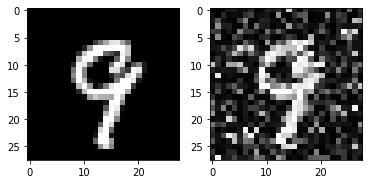

25  :  0.025519675456968594 25
50  :  0.13166850509948702 25
75  :  0.07234623658478129 25
100  :  0.26833401506390137 25
125  :  0.5225701639804066 25
150  :  0.6124310823966854 25
175  :  0.6502948969588424 25
200  :  0.6566285191205278 25
225  :  0.6589364319774773 25
250  :  0.6715734164290004 25
275  :  0.6715734164290004 25
300  :  0.6840927293612957 25
325  :  0.6913005253376356 25
350  :  0.6921556844137277 25
375  :  0.6926762420118364 25
400  :  0.6984285284496294 25
425  :  0.702049606748187 25
450  :  0.7040789761231638 25
475  :  0.7040556042418982 25
500  :  0.7049524971008253 25
525  :  0.7071360594237623 25
550  :  0.7111415679637176 25
575  :  0.7111909449849628 25
600  :  0.7133278193087196 25
625  :  0.7128567472587467 25
650  :  0.7168382405001479 25
675  :  0.7174001541346819 25
700  :  0.717616133307706 25
725  :  0.717616133307706 25
750  :  0.719797325062379 25
775  :  0.721069580955523 25
800  :  0.7208170000769245 25
825  :  0.7220435037264467 25
850  :  0.722

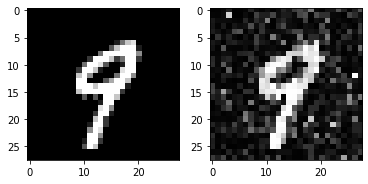

25  :  0.53212762535284 25
50  :  0.6220646472355449 25
75  :  0.6284063341357606 25
100  :  0.5726564957354784 25
125  :  0.6549135942535826 25
150  :  0.6678584818206598 25
175  :  0.6688921608356473 25
200  :  0.6688921608356473 25
225  :  0.6767032368356777 25
250  :  0.6798256047906084 25
275  :  0.6810054457169905 25
300  :  0.6801295620251542 25
325  :  0.6801295620251542 25
350  :  0.6806833805378695 25
375  :  0.6822679957496238 25
400  :  0.6843591764872534 25
425  :  0.6855150909078007 25
450  :  0.6858504372957848 25
475  :  0.6867482005670736 25
500  :  0.6893474866062609 25
525  :  0.6941186206497068 25
550  :  0.6947482769814186 25
575  :  0.6947290003003933 25
600  :  0.6954959810423262 25
625  :  0.6963909155677922 25
650  :  0.6963909155677922 25
675  :  0.6966801352479558 25
700  :  0.6966801352479558 25
725  :  0.6969342813607563 25
750  :  0.6977323606536922 25
775  :  0.6981191649544004 25
800  :  0.6990478891790033 25
825  :  0.6997092769728253 25
850  :  0.70023

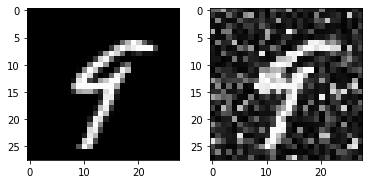

25  :  -0.13425863909798014 25
50  :  -0.13425863909798014 25
75  :  -0.13394466973265146 25
100  :  -0.13425863909798014 25
125  :  -0.13425863909798014 25
150  :  -0.13425863909798014 25
175  :  -0.13334563029864477 25
200  :  -0.13342538878721572 25
225  :  -0.13333449808515785 25
250  :  -0.1329060217096137 25
275  :  -0.13174565238978242 25
300  :  -0.13174565238978242 25
325  :  -0.13122011690808122 25
350  :  -0.13174332514917209 25
375  :  -0.13174332514917209 25
400  :  -0.13174332514917209 25
425  :  -0.13174332514917209 25
450  :  -0.13130686069759473 25
475  :  -0.1312082986409584 25
500  :  -0.13091064158543264 25
525  :  -0.1307833497923277 25
550  :  -0.12954485881343797 25
575  :  -0.1295833180013672 25
600  :  -0.1295833180013672 25
625  :  -0.12894373957827726 25
650  :  -0.12941864774486816 25
675  :  -0.1291894539430989 25
700  :  -0.12887871967576908 25
725  :  -0.12887428001887574 25
750  :  -0.12789531422063127 25
775  :  -0.12804429321365912 25
800  :  -0.127652

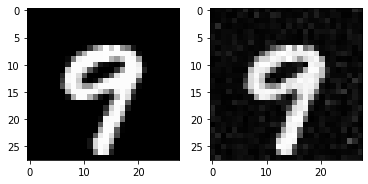

25  :  -0.055919160188642014 25
50  :  -0.041822977595755984 25
75  :  -0.05187840283143813 25
100  :  0.07586250177706871 25
125  :  0.18601145307658135 25
150  :  0.5211505321922375 25
175  :  0.5772724537041879 25
200  :  0.6758990992772251 25
225  :  0.6831089471773208 25
250  :  0.6918915292793927 25
275  :  0.6918915292793927 25
300  :  0.6936308796624386 25
325  :  0.6978128270112185 25
350  :  0.7019999727163537 25
375  :  0.7045541363686088 25
400  :  0.7102958939267144 25
425  :  0.7116816940018958 25
450  :  0.7141114005934661 25
475  :  0.7185388710367975 25
500  :  0.7196630283599206 25
525  :  0.7228480287249353 25
550  :  0.7228427087840847 25
575  :  0.7229077769418475 25
600  :  0.723585666841823 25
625  :  0.7259965405047571 25
650  :  0.7260026981420846 25
675  :  0.7266753084110075 25
700  :  0.7271456352644571 25
725  :  0.7283906482059266 25
750  :  0.7283596027377762 25
775  :  0.7283596027377762 25
800  :  0.7289616112415 25
825  :  0.7292236721567291 25
850  : 

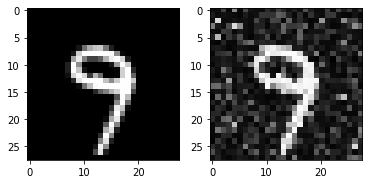

25  :  0.7813238635592992 25
50  :  0.7813238635592992 25
75  :  0.7702775139272203 25
100  :  0.7666692646567511 25
125  :  0.7501720739838502 25
150  :  0.7500963782598362 25
175  :  0.7588754039405234 25
200  :  0.7590206868287475 25
225  :  0.7772443325077175 25
250  :  0.7772833014256963 25
275  :  0.7798691158083271 25
300  :  0.7825167359626629 25
325  :  0.7842360808261272 25
350  :  0.7851061459871851 25
375  :  0.7858636771887979 25
400  :  0.7869910941861911 25
425  :  0.7902067141398126 25
450  :  0.7902067141398126 25
475  :  0.7902067141398126 25
500  :  0.7910877180131619 25
525  :  0.7911696134943835 25
550  :  0.7911696134943835 25
575  :  0.7919141224244399 25
600  :  0.7915961296658072 25
625  :  0.7927343291399609 25
650  :  0.7927499045117655 25
675  :  0.7939655769116849 25
700  :  0.797887358203416 25
725  :  0.7973514746454078 25
750  :  0.797374630478477 25
775  :  0.797374630478477 25
800  :  0.797374630478477 25
825  :  0.7983270507884301 25
850  :  0.7983697

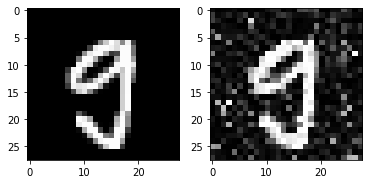

25  :  -0.09122242005922182 25
50  :  -0.06842314571283847 25
75  :  0.024922590997582733 25
100  :  0.2552892804051834 25
125  :  0.24605506360592033 25
150  :  0.4448270968940259 25
175  :  0.6507740238734605 25
200  :  0.6389890125626219 25
225  :  0.668371202306083 25
250  :  0.6674879927014293 25
275  :  0.6674879927014293 25
300  :  0.6692224068581321 25
325  :  0.6707613236929358 25
350  :  0.6707613236929358 25
375  :  0.6746821016802154 25
400  :  0.6804044739583879 25
425  :  0.6818625286402457 25
450  :  0.6818625286402457 25
475  :  0.6834990789086485 25
500  :  0.6848343037174861 25
525  :  0.6870037140752038 25
550  :  0.6907799390391076 25
575  :  0.6921995362366404 25
600  :  0.6955095303005518 25
625  :  0.69730704599343 25
650  :  0.6990470477485662 25
675  :  0.6990553857279496 25
700  :  0.6992245984233282 25
725  :  0.6994291045341359 25
750  :  0.7011140983511517 25
775  :  0.7027149180626022 25
800  :  0.7035274556758845 25
825  :  0.7051699868202727 25
850  :  0

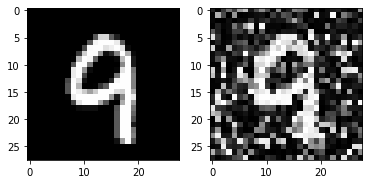

25  :  -0.012796020719621937 25
50  :  0.15592565784492285 25
75  :  0.21963716936151445 25
100  :  0.05234131697856548 25
125  :  0.03885719181258529 25
150  :  0.06266688335825366 25
175  :  0.3139368313227624 25
200  :  0.3348261695464981 25
225  :  0.47589214699184335 25
250  :  0.5868396286594045 25
275  :  0.5779943294010184 25
300  :  0.6255752986584686 25
325  :  0.6251812221150517 25
350  :  0.6605457912696253 25
375  :  0.6620873786423547 25
400  :  0.6636642934804072 25
425  :  0.675639580260702 25
450  :  0.6780293024259136 25
475  :  0.687663036000256 25
500  :  0.687663036000256 25
525  :  0.6891559117822064 25
550  :  0.6931466524026533 25
575  :  0.6983560568231283 25
600  :  0.6985035426048023 25
625  :  0.6986022122850608 25
650  :  0.7043328964378657 25
675  :  0.7052786212903679 25
700  :  0.7065898466746945 25
725  :  0.7091763121629066 25
750  :  0.7101914672160751 25
775  :  0.7129054269871737 25
800  :  0.7172807549428615 25
825  :  0.7210210316037844 25
850  : 

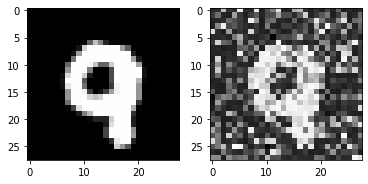

In [22]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28*28) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_rbf_mnist_ssim', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [24]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

152.30947828292847
49.68615007400513
79.28696333605146
18.42985744210329


In [25]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1908
800
1106.7619047619048
215.68846686651798


In [26]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

28.581169458494372
7.328917208390699
14.76640563890555
5.9523651916641755
